<a href="https://colab.research.google.com/github/satrio-hw/CapstoneProject_DataMining/blob/master/damin_capstone_0102517023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **R Satrio H Wicaksono (0102517023)**
# Capstone Project Data Mining

Pada _Capstone Project_ ini saya akan mencoba untuk melakukan analisis terhadap artikel berita yang didapat dari https://ilps.science.uva.nl/ilps/wp-content/uploads/sites/6/files/bahasaindonesia/.<br><br>
Dari data yang tersedia, saya mengambil data artikel berita kompas dengan detail : <br>


1.   Data di ekstrak dari file dengan ekstensi *.txt*
2.   Data kumpulan artikel tertanggal dari Januari 2001 hingga Desember 2002 (**terkecuali Agustus 2002 dan September 2002**)

3.   Data berupa kumpulan dari total 5449 artikel
4.   Tiap record terdiri dari 'Judul Artikel', 'Tanggal Terbit' dan jumlah frekuensi kemunculan tiap kata dalam artikel tersebut

---


_In this Capstone Project, I am striving to investigate the news articles from https://ilps.science.uva.nl/ilps/wp-content/uploads/sites/6/files/bahasaindonesia/._
<br><br>
_The available data gathered from the Kompas news articles are as follows:_<br>
1. _The data is extracted from files with a .txt extension_ <br>
2. _Data collection of the articles is from January 2001 to December 2002 (except August 2002 and September 2002)_<br>
3. _The data is a collection of a total of 5449 news articles_<br>
4. _Each record consists of the 'Article Title', 'Date of Publication' and the number of times each word appeared in the news articles_

# **PREPARATION**

## Enable CUDA for preprocessing <br>
Untuk melakukan ekstraksi 5449 artikel, saya menggunakan google colab dengan GPU. Dikarenakan jumlah yang besar, artikel akan dikelompokan kedalam 22 folder yang tiap foldernya merepresentasikan bulan terbit artikel didalamnya. Seluruh artikel akan dijadikan dataset sesuai dengan bulan dan tahun terbitnya.<br><br>

Proses ekstraksi juga disertai dengan _preprocessing_ untuk isi artikel. Untuk mempermudah komputasi, proses ini akan dilakukan sebanyak 4 kali dengan tiap satu kali proses akan mengolah 5-6 folder.


---
_To extract 5449 articles, I used google collab with GPU. Considering the large number, those were grouped into 22 folders based on the month when the article was published. All the news articles were arranged into a dataset according to the month and year of publication.<br><br>
The extraction process is also followed by preprocessing the contents of the article. The extractions process will be divided into 4 different batches, and each will process 5-6 folders to make the computation easier._



In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Import Library<br>

Library yang digunakan untuk preprocessing adalah **nltk**, yang nantinya digunakan pada tahapan *tokenization* dan *remove stopwords* isi artikel. Library **re** digunakan dalam proses _filtering_ menggunakan ekspresi _regex_ yang sesuai untuk menghilangkan semua angka didalam artikel.


---
_The library used for preprocessing is **nltk**, which is used in the tokenization and remove stopwords phase.
The **re** library used in the filtering process implements the appropriate regex expression to remove all numbers in the article._


In [ ]:
import nltk
import pandas as pd
nltk.download('punkt')
nltk.download('stopwords')
import string
import re

import os
from datetime import date

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
!pip install sastrawi

#Library tambahan
from scipy.stats import norm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from scipy.sparse import csr_matrix
from scipy import stats
from sklearn.metrics import r2_score

sns.set(style='whitegrid')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


_Library_ **Sastrawi**, digunakan untuk proses *stemming* bahasa Indonesia, dimana tiap kata berimbuhan pada isi artikel akan dikembalikan ke bentuk bakunya untuk kemudian dijadikan _token_. Hal ini nantinya berfungsi untuk mengurangi *noice* pada dataframe yang dihasilkan.


---
_Library **Sastrawi**, is used for the stemming process of the Indonesian language, where each word affixing the contents of the article will be returned to its standard form and then used as a token. That will later reduce the noise at the end of the dataframe._

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

Untuk mempermudah pengambilan data *.txt*, semua data mentah diletakan di google drive.


---

_To simplify data extraction (with extension *.txt*), all related data stored in Google Drive._


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## New Session on GDrive<br>
Untuk tiap kode *authorization* yang diberikan, terdapat batasan waktu tertentu untuk mengakses google drive. Hal ini juga merupakan salah satu alasan ekstraksi dilakukan secara bertahap.


---

_Every authorization token has a specific time limit to access the Google Drive directory. It became one of the main reasons why the extraction process was done in multiple batches._


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_path = 'gdrive/My Drive/damin_capstone/dataset_berita'

## **GET THE DATA**

### Dataset Articles 2001-2002

22 dataset (dari 22 folder) akan dibentuk dengan atribut **"Judul Artikel", "Tanggal_Terbit", "Isi Artikel", "sum_char_judul" dan "sum_char_isi"**

---

_22 Datasets (from 22 folders) consist of multiple attributes such as **"Judul Artikel" (Title of articles), "Tanggal_Terbit" (Release date), "Isi Artikel" (Article Content), "sum_char_judul" (total character in title) and "sum_char_isi" (total character in content)**_

#### Dataframe **First 2001 (no freq)**<br>
Dataframe yang pertama akan dibentuk dari artikel yang terbit pada **Januari 2001 - Juni 2001**

---

_The first dataframe consists of articles released in January 2001 - June 2001_

In [ ]:
count_f=0
count=0
for folder in os.listdir('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20011/'):
  for txtfile in os.listdir(('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20011/'+folder)):
    count+=1
    #print(txtfile)
  count_f+=1
print('jumlah file : ',count)
print('jumlah folder : ',count_f)

jumlah file :  1545
jumlah folder :  6


In [ ]:
import os
from datetime import date

# List all files in a directory using os.listdir
listtitle=[]
listyear=[]
listmonth=[]
listday=[]

In [ ]:
for folder in os.listdir('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20011/'):
  main_df = pd.DataFrame() #Dataframe untuk frequensi tiap kata
  for txtfile in os.listdir(('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20011/'+folder)):
    #count+=1
    #print(txtfile)

    """ Open file """
    f=open(('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20011/'+folder+'/'+txtfile),"rb")
    isifile=f.read()
    rawtext=str(isifile)

    """ ----Extraksi detail tiap artikel ke dalam 1 dataframe START---- """
    title=[]
    temp=None
    for karakter_index in range (len(rawtext)):
      if karakter_index >= 2:
        if rawtext[karakter_index] == "n" and rawtext[karakter_index-1] == "\\":
          mulaiisi_idx=karakter_index-1
          break;
        title.append(rawtext[karakter_index])
    title.pop()

    listtitle.append(''.join(title))
    listday.append(txtfile[0:2])
    listmonth.append(txtfile[4:6])
    listyear.append('20'+txtfile[2:4])

    #maindetail_df = maindetail_df.append({'artikel':str(txtfile),'judul':str(listtitle[len(listtitle)-1]), 'tanggal':pd.Timestamp(date(int(listyear[len(listyear)-1]),int(listmonth[len(listmonth)-1]),int(listday[len(listday)-1])))},ignore_index=True, sort=True)
    """ ----Extraksi detail tiap artikel ke dalam 1 dataframe END---- """

    """ Stemmer init """
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    """ ---- Cleaning text START ---- """
    textisi=rawtext[mulaiisi_idx:len(rawtext)]
    
    textisi=textisi.strip('\\n') #remove trailing newline
    textisi=textisi.replace('\\r\\n\\n','') #remove \r\n\n
    textisi = re.sub(r"\d+", "", textisi) #remove number
    
    textisi = textisi.translate(str.maketrans(' ',' ',string.punctuation)).lower() #remove symbols   
    """ ---- Cleaning text END ---- """

    """ Handling attribute ke dataframe START """
    row_df = pd.DataFrame()
    row_df['Judul_Artikel']=[str(listtitle[len(listtitle)-1])]
    row_df['Tanggal_Terbit']=pd.Timestamp(date(int(listyear[len(listyear)-1]),int(listmonth[len(listmonth)-1]),int(listday[len(listday)-1])))
    row_df['Isi_Artikel']=[str(textisi)]
    row_df['len_Isi_Artikel']=[len(textisi)]
    row_df['len_Judul']=[len(listtitle[len(listtitle)-1])]
    
    main_df=main_df.append(row_df, ignore_index=True, sort=True) #semua row(artikel) akan digabung di dalam 1 dataframe 
    """ Handling attribute ke dataframe END """
    
    #print('loop File ',txtfile)

  main_df.to_csv(r'/content/drive/My Drive/maindetail20011notoken_'+str(listmonth[len(listmonth)-1])+'.csv')
  print('loop maindetail20011notoken_',folder)

print('done') #ada 5449 files di 22 folder

loop maindetail20011notoken_ 022001
loop maindetail20011notoken_ 012001
loop maindetail20011notoken_ 032001
loop maindetail20011notoken_ 042001
loop maindetail20011notoken_ 062001
loop maindetail20011notoken_ 052001
done


#### Dataframe **SECOND 2001 (no freq)**<br>

Dataframe yang kedua akan dibentuk dari artikel yang terbit pada **Juli 2001 - Desember 2001**

---

_The second dataframe consists of articles released in July 2001 - December 2001_


In [ ]:
count_f=0
count=0
for folder in os.listdir('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20012/'):
  for txtfile in os.listdir(('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20012/'+folder)):
    count+=1
    #print(txtfile)
  count_f+=1
print('jumlah file : ',count)
print('jumlah folder : ',count_f)

jumlah file :  1615
jumlah folder :  6


In [ ]:
import os
from datetime import date

# List all files in a directory using os.listdir
listtitle=[]
listyear=[]
listmonth=[]
listday=[]

In [ ]:
for folder in os.listdir('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20012/'):
  main_df = pd.DataFrame() #Dataframe untuk frequensi tiap kata
  for txtfile in os.listdir(('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20012/'+folder)):
    #count+=1
    #print(txtfile)

    """ Open file """
    f=open(('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20012/'+folder+'/'+txtfile),"rb")
    isifile=f.read()
    rawtext=str(isifile)

    """ ----Extraksi detail tiap artikel ke dalam 1 dataframe START---- """
    title=[]
    temp=None
    for karakter_index in range (len(rawtext)):
      if karakter_index >= 2:
        if rawtext[karakter_index] == "n" and rawtext[karakter_index-1] == "\\":
          mulaiisi_idx=karakter_index-1
          break;
        title.append(rawtext[karakter_index])
    title.pop()

    listtitle.append(''.join(title))
    listday.append(txtfile[0:2])
    listmonth.append(txtfile[4:6])
    listyear.append('20'+txtfile[2:4])

    #maindetail_df = maindetail_df.append({'artikel':str(txtfile),'judul':str(listtitle[len(listtitle)-1]), 'tanggal':pd.Timestamp(date(int(listyear[len(listyear)-1]),int(listmonth[len(listmonth)-1]),int(listday[len(listday)-1])))},ignore_index=True, sort=True)
    """ ----Extraksi detail tiap artikel ke dalam 1 dataframe END---- """

    """ Stemmer init """
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    """ ---- Cleaning text START ---- """
    textisi=rawtext[mulaiisi_idx:len(rawtext)]
    
    textisi=textisi.strip('\\n') #remove trailing newline
    textisi=textisi.replace('\\r\\n\\n','') #remove \r\n\n
    textisi = re.sub(r"\d+", "", textisi) #remove number
    
    textisi = textisi.translate(str.maketrans(' ',' ',string.punctuation)).lower() #remove symbols   
    """ ---- Cleaning text END ---- """

    """ Handling attribute ke dataframe START """
    row_df = pd.DataFrame()
    row_df['Judul_Artikel']=[str(listtitle[len(listtitle)-1])]
    row_df['Tanggal_Terbit']=pd.Timestamp(date(int(listyear[len(listyear)-1]),int(listmonth[len(listmonth)-1]),int(listday[len(listday)-1])))
    row_df['Isi_Artikel']=[str(textisi)]
    row_df['len_Isi_Artikel']=[len(textisi)]
    row_df['len_Judul']=[len(listtitle[len(listtitle)-1])]
    
    main_df=main_df.append(row_df, ignore_index=True, sort=True) #semua row(artikel) akan digabung di dalam 1 dataframe 
    """ Handling attribute ke dataframe END """
    
    #print('loop File ',txtfile)

  main_df.to_csv(r'/content/drive/My Drive/maindetail20012notoken_'+str(listmonth[len(listmonth)-1])+'.csv')
  print('loop maindetail20012notoken_',folder)

print('done') #ada 5449 files di 22 folder

loop maindetail20012notoken_ 092001
loop maindetail20012notoken_ 102001
loop maindetail20012notoken_ 082001
loop maindetail20012notoken_ 072001
loop maindetail20012notoken_ 122001
loop maindetail20012notoken_ 112001
done


#### Dataframe **FIRST 2002 (no freq)**<br>
Dataframe yang pertama akan dibentuk dari artikel yang terbit pada **Juni, Juli, Oktober, November dan Desember 2002**

---

_The first dataframe (in 2002) consists of articles released in June, July, October, November, and December 2002_

In [ ]:
count_f=0
count=0
for folder in os.listdir('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20021/'):
  for txtfile in os.listdir(('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20021/'+folder)):
    count+=1
    #print(txtfile)
  count_f+=1
print('jumlah file : ',count)
print('jumlah folder : ',count_f)

jumlah file :  1069
jumlah folder :  5


In [ ]:
import os
from datetime import date

# List all files in a directory using os.listdir
listtitle=[]
listyear=[]
listmonth=[]
listday=[]

In [ ]:
for folder in os.listdir('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20021/'):
  main_df = pd.DataFrame() #Dataframe untuk frequensi tiap kata
  for txtfile in os.listdir(('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20021/'+folder)):
    #count+=1
    #print(txtfile)

    """ Open file """
    f=open(('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20021/'+folder+'/'+txtfile),"rb")
    isifile=f.read()
    rawtext=str(isifile)

    """ ----Extraksi detail tiap artikel ke dalam 1 dataframe START---- """
    title=[]
    temp=None
    for karakter_index in range (len(rawtext)):
      if karakter_index >= 2:
        if rawtext[karakter_index] == "n" and rawtext[karakter_index-1] == "\\":
          mulaiisi_idx=karakter_index-1
          break;
        title.append(rawtext[karakter_index])
    title.pop()

    listtitle.append(''.join(title))
    listday.append(txtfile[0:2])
    listmonth.append(txtfile[4:6])
    listyear.append('20'+txtfile[2:4])

    #maindetail_df = maindetail_df.append({'artikel':str(txtfile),'judul':str(listtitle[len(listtitle)-1]), 'tanggal':pd.Timestamp(date(int(listyear[len(listyear)-1]),int(listmonth[len(listmonth)-1]),int(listday[len(listday)-1])))},ignore_index=True, sort=True)
    """ ----Extraksi detail tiap artikel ke dalam 1 dataframe END---- """

    """ Stemmer init """
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    """ ---- Cleaning text START ---- """
    textisi=rawtext[mulaiisi_idx:len(rawtext)]
    
    textisi=textisi.strip('\\n') #remove trailing newline
    textisi=textisi.replace('\\r\\n\\n','') #remove \r\n\n
    textisi = re.sub(r"\d+", "", textisi) #remove number
    
    textisi = textisi.translate(str.maketrans(' ',' ',string.punctuation)).lower() #remove symbols   
    """ ---- Cleaning text END ---- """

    """ Handling attribute ke dataframe START """
    row_df = pd.DataFrame()
    row_df['Judul_Artikel']=[str(listtitle[len(listtitle)-1])]
    row_df['Tanggal_Terbit']=pd.Timestamp(date(int(listyear[len(listyear)-1]),int(listmonth[len(listmonth)-1]),int(listday[len(listday)-1])))
    row_df['Isi_Artikel']=[str(textisi)]
    row_df['len_Isi_Artikel']=[len(textisi)]
    row_df['len_Judul']=[len(listtitle[len(listtitle)-1])]
    
    main_df=main_df.append(row_df, ignore_index=True, sort=True) #semua row(artikel) akan digabung di dalam 1 dataframe 
    """ Handling attribute ke dataframe END """
    
    #print('loop File ',txtfile)

  main_df.to_csv(r'/content/drive/My Drive/todataframe20021notoken_'+str(listmonth[len(listmonth)-1])+'.csv')
  print('loop todataframe20021notoken_',folder)

print('done') #ada 5449 files di 22 folder

loop todataframe20021notoken_ 072002
loop todataframe20021notoken_ 062002
loop todataframe20021notoken_ 102002
loop todataframe20021notoken_ 122002
loop todataframe20021notoken_ 112002
done


#### Dataframe **SECOND 2002 (no freq)**<br>
Dataframe yang kedua akan dibentuk dari artikel yang terbit pada **Januari 2002 - Mei 2002**

---

_The second dataframe (in 2002) consists of articles released in January 2001 - May 2001_

In [ ]:
count_f=0
count=0
for folder in os.listdir('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20022/'):
  for txtfile in os.listdir(('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20022/'+folder)):
    count+=1
    #print(txtfile)
  count_f+=1
print('jumlah file : ',count)
print('jumlah folder : ',count_f)

jumlah file :  1220
jumlah folder :  5


In [ ]:
import os
from datetime import date

# List all files in a directory using os.listdir
listtitle=[]
listyear=[]
listmonth=[]
listday=[]

In [ ]:
for folder in os.listdir('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20022/'):
  main_df = pd.DataFrame() #Dataframe untuk frequensi tiap kata
  for txtfile in os.listdir(('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20022/'+folder)):
    #count+=1
    #print(txtfile)

    """ Open file """
    f=open(('/content/drive/My Drive/damin_capstone/dataset_berita/kompas/txt/todataframe20022/'+folder+'/'+txtfile),"rb")
    isifile=f.read()
    rawtext=str(isifile)

    """ ----Extraksi detail tiap artikel ke dalam 1 dataframe START---- """
    title=[]
    temp=None
    for karakter_index in range (len(rawtext)):
      if karakter_index >= 2:
        if rawtext[karakter_index] == "n" and rawtext[karakter_index-1] == "\\":
          mulaiisi_idx=karakter_index-1
          break;
        title.append(rawtext[karakter_index])
    title.pop()

    listtitle.append(''.join(title))
    listday.append(txtfile[0:2])
    listmonth.append(txtfile[4:6])
    listyear.append('20'+txtfile[2:4])

    #maindetail_df = maindetail_df.append({'artikel':str(txtfile),'judul':str(listtitle[len(listtitle)-1]), 'tanggal':pd.Timestamp(date(int(listyear[len(listyear)-1]),int(listmonth[len(listmonth)-1]),int(listday[len(listday)-1])))},ignore_index=True, sort=True)
    """ ----Extraksi detail tiap artikel ke dalam 1 dataframe END---- """

    """ Stemmer init """
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    """ ---- Cleaning text START ---- """
    textisi=rawtext[mulaiisi_idx:len(rawtext)]
    
    textisi=textisi.strip('\\n') #remove trailing newline
    textisi=textisi.replace('\\r\\n\\n','') #remove \r\n\n
    textisi = re.sub(r"\d+", "", textisi) #remove number
    
    textisi = textisi.translate(str.maketrans(' ',' ',string.punctuation)).lower() #remove symbols   
    """ ---- Cleaning text END ---- """

    """ Handling attribute ke dataframe START """
    row_df = pd.DataFrame()
    row_df['Judul_Artikel']=[str(listtitle[len(listtitle)-1])]
    row_df['Tanggal_Terbit']=pd.Timestamp(date(int(listyear[len(listyear)-1]),int(listmonth[len(listmonth)-1]),int(listday[len(listday)-1])))
    row_df['Isi_Artikel']=[str(textisi)]
    row_df['len_Isi_Artikel']=[len(textisi)]
    row_df['len_Judul']=[len(listtitle[len(listtitle)-1])]
    
    main_df=main_df.append(row_df, ignore_index=True, sort=True) #semua row(artikel) akan digabung di dalam 1 dataframe 
    """ Handling attribute ke dataframe END """
    
    #print('loop File ',txtfile)

  main_df.to_csv(r'/content/drive/My Drive/todataframe20022notoken_'+str(listmonth[len(listmonth)-1])+'.csv')
  print('loop todataframe20022notoken_',folder)

print('done') #ada 5449 files di 22 folder

loop todataframe20022notoken_ 032002
loop todataframe20022notoken_ 012002
loop todataframe20022notoken_ 022002
loop todataframe20022notoken_ 042002
loop todataframe20022notoken_ 052002
done


#**THE PROBLEMS**

Pada Capstone ini saya akan mencoba untuk menjelaskan tentang data timeseries yang berupa artikel berita. Pertanyaan yang ingin dijawab pada akhir project ini adalah :<br>
1. Apakah takaran sebuah artikel berita dapat dikatakan 'mirip' antar satu dengan lainnya bila yang diketahui hanya judul dan isi dari artikel saja?
2. Apakah ada keterkaitan antara panjang artikel dengan frekuensi kemunculan beberapa artikel yang mirip?
3. Apakah ada aturan/pola tersendiri dalam penulisan berita untuk waktu-waktu tertentu?<br>

---
_In this Capstone, I will try to explain time-series data in the form of news articles. The questions to be answered at the end of this project are:_<br>
1. _What is the standard that a news article can be said to be 'similar' to one another? (assuming that the title and content of the article are known)_<br>
2. _Is there any correlation between the length and the appearance of similar articles?_<br>
3. _Are there separate rules/patterns in writing news related to time-series?_

#**Q1. Apakah takaran sebuah artikel berita dapat dikatakan 'mirip' antar satu dengan lainnya bila yang diketahui hanya judul dan isi dari artikel saja?**

**Q1.What is the standard that a news article can be said to be 'similar' to one another? (assuming that the title and content of the article are known)**<br><br><br>
Untuk pertanyaan pertama, saya akan menggunakan **_cosine similarity_** sebagai takaran kemiripan antar artikel. Mengingat gaya penulisan yang beragam, akan ada kemungkinan kata yang kurang begitu penting memiliki frekuensi lebih dibandingkan dengan kata kunci pada artikel. Oleh karena itu saya menggunakan **Bag of Words** dengan nilai _binary_. BoW menyatakan apakah sebuah kata dalam sebuah artikel juga terdapat di artikel lainnya. Hadir tidaknya sebuah kata dalam artikel dilambangkan dengan nilai _binary_ 0 atau 1. Semakin banyak kata yang beririsan antar artikel, semakin mirip kedua artikel tersebut.<br><br>

_Cosine Similarity_ menghasilkan produk skalar dalam metrix NxN, dimana tiap bagiannya berisi value **0.0-1.0**. _Cosine Similarity_ dipilih karena saya akan membandingkan orientasi dari dua dokumen berbeda, sehingga frekuensi kemunculan sebuah kata kurang relevan bila dijadikan acuan "kemiripan" antar dokumen. 

Mengingat pula dikarenakan penulisan artikel yang terkesan bebas, perlu adanya acuan atau _Boundary Value_ yang akan digunakan sebagai pembanding hasil _Cosine Similarity_ nantinya.<br>

Untuk itu, saya mencoba mencari nilai _cosine similarity_ dari 6 artikel CNN yang bertemakan tentang banjir di Jakarta pada Januari 2020. Artikel ini diambil dan dituliskan kembali secara manual dan melalui proses baik _stemming, tokenizing_, dll yang nantinya juga akan diterapkan pada dataset yang dijadikan objek pengamatan. Keenam artikel diupload pada hari yang sama (2/1/2020) dengan format _.txt_ yang berisi konten dari masing-masing artikel.

<br>

---
<br>

_For the first question, I will implement cosine similarity to measure the similarity between articles. As the variety of writing styles, trivial words might frequently appear than the keywords of the article. Therefore, I used Bag of Words (BoW) with binary values. BoW states whether a single word in a news article appears in another article. The presence or absence of a single word, denoted by using a binary value of 0 or 1. The more words that intersect between articles, the more similar the two articles will be._ <br>

_Cosine Similarity generates a scalar product in the NxN matrix, in which each part contains the value of 0.0-1.0. Cosine Similarity was applied because I will compare the orientations of two different documents. Hence, the frequency of occurrence of a word is less relevant when used as a reference for "similarity" between documents._ <br>

_As the writing of articles tends to be irregular, a reference or Boundary Value is needed. It is as a threshold for the Cosine Similarity calculation results later. Consequently, I tried to find the cosine similarity value from 6 CNN articles with a theme related to floods in Jakarta in January 2020. These articles were taken and rewritten manually and using stemming, tokenizing, etc. The process will be applied to the dataset used as the object observation. The six articles were uploaded on the same day (2/1/2020) in .txt format focusing on the content of the article._

In [ ]:
count_f=0
count=0
for folder in os.listdir('/content/drive/My Drive/damin_capstone/cnn/'):
  count+=1
  #print(txtfile)
  count_f+=1
print('jumlah file : ',count)
print('jumlah folder : ',count_f)

jumlah file :  6
jumlah folder :  6


In [ ]:
main_df = pd.DataFrame()
for txtfile in os.listdir('/content/drive/My Drive/damin_capstone/cnn/'):
  """ Open file """
  f=open(('/content/drive/My Drive/damin_capstone/cnn/'+txtfile),"rb")
  isifile=f.read()
  textisi=str(isifile)
    
  textisi=textisi.strip('\\n') #remove trailing newline
  textisi=textisi.replace('\\r\\n\\n','') #remove \r\n\n
  textisi = re.sub(r"\d+", "", textisi) #remove number
    
  textisi = textisi.translate(str.maketrans(' ',' ',string.punctuation)).lower() #remove symbols
  temp=pd.DataFrame({'isi_artikel':[textisi]})
  main_df=main_df.append(temp, ignore_index=True, sort=True)

In [ ]:
from sklearn.feature_extraction import text 

listStopword =  set(nltk.corpus.stopwords.words('indonesian'))
stop_words = text.ENGLISH_STOP_WORDS.union(listStopword)

vect = CountVectorizer(binary=True, max_features=None, stop_words=stop_words)
matrix = vect.fit_transform(main_df['isi_artikel'])

attribute_names=vect.get_feature_names()
print('Feature dengan Tambahan nltk: ',len(attribute_names))

bow_matrix=pd.DataFrame(matrix.toarray(),columns=attribute_names)
display(bow_matrix)

display(cosine_similarity(bow_matrix))
ratarata=((cosine_similarity(bow_matrix).sum())-6)/30
print('\nrata-rata cosine sim. dari keenam artikel : ',ratarata)

Feature dengan Tambahan nltk:  500


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,age,agus,air,akademika,akibat,akses,aktivitas,alam,alat,alumni,anak,anggrek,angkutan,api,arah,arahan,area,argo,armada,arus,aturan,awak,awan,awanawan,ayu,badan,bahan,bala,balai,balita,banjir,banjirrnrnmenurut,banjirrnrntak,bantuan,banyaknya,barang,barat,bekasi,bekasirnrnwarga,bekti,...,tersebutrnrnkami,tersedia,tersengat,terseret,tertimbun,tertutupnya,tibarnrnsejumlah,tikar,tim,timnya,timur,tindakan,tinggalnya,tinggalrnrnwakil,tinggirnrnya,titik,toilet,tol,ton,tri,trirnrnpihaknya,tujuh,turi,turun,ujarnyarnrnbeberapa,ujarnyarnrnkepala,universitas,untar,upaya,utama,warga,wib,wibowo,wibrnrnsebelumnya,wilayah,wilayahnya,yitro,yogyakarta,yogyakartarnrnmeskipun,zunantarnrnmenurut
0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0
1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,1,1,0,...,0,0,1,1,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,1,0,0,0,0
2,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,1,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,1,0,1,1,0,1,0,1,1,0,0,1,0,1,1,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,1,1,1,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,...,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,1


array([[1.        , 0.0993808 , 0.08018754, 0.08333333, 0.07290148,
        0.10825318],
       [0.0993808 , 1.        , 0.12431798, 0.26501546, 0.16518617,
        0.11475506],
       [0.08018754, 0.12431798, 1.        , 0.17106675, 0.05611959,
        0.09259259],
       [0.08333333, 0.26501546, 0.17106675, 1.        , 0.11664237,
        0.11226255],
       [0.07290148, 0.16518617, 0.05611959, 0.11664237, 1.        ,
        0.12626907],
       [0.10825318, 0.11475506, 0.09259259, 0.11226255, 0.12626907,
        1.        ]])


rata-rata cosine sim. dari keenam artikel :  0.11921892785169745


Dari perhitungan diatas, untuk kasus ini dapat **diasumsikan** bahwa artikel dengan nilai **_cosine similarity_ $\approx$ 0.12** sudah dapat dikatakan memiliki kemiripan tema antar satu dengan lainnya.<br>

---

_From the calculations above, in this case, it can **be assumed** that articles with a **cosine similarity value of ≈ 0.12** can be said to have similar themes to one another._

## Load dataset

In [ ]:
csv_path = '/content/drive/My Drive/damin_capstone/dataset_berita/kompas/csv_files/notoken'

In [ ]:
count=0
for files in os.listdir(csv_path):
  count+=1
print('jumlah file : ',count)

jumlah file :  22


In [ ]:
pd.set_option('display.max_rows', 15)

df2001 = pd.DataFrame()
df2002 = pd.DataFrame()
temp1 = pd.DataFrame()
temp2 = pd.DataFrame()

idx=0
for files in os.listdir(csv_path):
  if str(files).find('2001') != -1:
    temp1=pd.read_csv(csv_path+'/'+files)
    df2001= df2001.append(temp1, ignore_index=True)

  elif str(files).find('2002') !=-1:
    temp2=pd.read_csv(csv_path+'/'+files)
    df2002= df2002.append(temp2, ignore_index=True)
  else:
    print('not included: ', files)


In [ ]:
df2001['Tanggal_Terbit']=pd.to_datetime(df2001['Tanggal_Terbit'])
df2002['Tanggal_Terbit']=pd.to_datetime(df2002['Tanggal_Terbit'])
df2001.columns=['Index_artikel','Isi_Artikel',	'Judul_Artikel',	'Tanggal_Terbit',	'len_Isi_Artikel',	'len_Judul']
df2002.columns=['Index_artikel','Isi_Artikel',	'Judul_Artikel',	'Tanggal_Terbit',	'len_Isi_Artikel',	'len_Judul']

df2001=df2001.sort_values(by=['Tanggal_Terbit', 'Index_artikel'], ascending=[True, True])
df2002=df2002.sort_values(by=['Tanggal_Terbit', 'Index_artikel'], ascending=[True, True])

print('Menampilkan info untuk dataset yang di load (kedua dataset identik):')
display(df2001.info())
print('\nDATASET ARTIKEL 2001')
display(df2001.head())
display(df2002.info())
print('\nDATASET ARTIKEL 2002')
display(df2002.head())

Menampilkan info untuk dataset yang di load (kedua dataset identik):
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3160 entries, 0 to 3159
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Index_artikel    3160 non-null   int64         
 1   Isi_Artikel      3160 non-null   object        
 2   Judul_Artikel    3160 non-null   object        
 3   Tanggal_Terbit   3160 non-null   datetime64[ns]
 4   len_Isi_Artikel  3160 non-null   int64         
 5   len_Judul        3160 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 172.8+ KB


None


DATASET ARTIKEL 2001


,Index_artikel,Isi_Artikel,Judul_Artikel,Tanggal_Terbit,len_Isi_Artikel,len_Judul
0,0,lima orang tewas dan sekitar cedera di antar...,Api dan Bom Sambut Awal Milenium Baru,2001-01-02,4836,37
1,1,presiden abdurrahman wahid mengatakan di balik...,Pertumbuhan Ekonomi Lebih Baik dari Perkiraan,2001-01-02,6212,45
2,2,upaya melly sebut saja begitu siasia bunyi ya...,Harapan Tahun Baru dari Tepian Rel,2001-01-02,5118,34
3,3,malam pergantian tahun dari ke di jakarta se...,Malam Pergantian Tahun Berlangsung Aman,2001-01-02,5943,39
4,4,suasana pergantian tahun diwarnai peristiwa tr...,"Bus Sinar Jaya Hantam Minibus, 10 Orang Tewas",2001-01-02,2911,45


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2289 entries, 1069 to 1068
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Index_artikel    2289 non-null   int64         
 1   Isi_Artikel      2289 non-null   object        
 2   Judul_Artikel    2289 non-null   object        
 3   Tanggal_Terbit   2289 non-null   datetime64[ns]
 4   len_Isi_Artikel  2289 non-null   int64         
 5   len_Judul        2289 non-null   int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 125.2+ KB


None


DATASET ARTIKEL 2002


,Index_artikel,Isi_Artikel,Judul_Artikel,Tanggal_Terbit,len_Isi_Artikel,len_Judul
1069,0,sebagian besar bursa utama dunia menutup trans...,Bursa Dunia Ditutup Terpuruk,2002-01-02,5619,28
1070,1,jabatan presiden di argentina saat ini nyaris ...,Presiden Rodriguez Saa Mundur Argentina Cari ...,2002-01-02,3942,59
1071,2,pemerintah daerah pemda dki jakarta dan badan ...,"Disepakati, Gunakan Marunda sebagai TPA",2002-01-02,3691,39
1072,3,pemerintah memastikan akan menaikkan tarif das...,Tarif Listrik Naik Enam Persen Per 1 Janua...,2002-01-02,6493,53
1073,4,dana kemanusiaan kompas dkk yang disalurkan ke...,DKK Salurkan Rp 148.400.000 pada November 2001,2002-01-02,1793,46


**_Haruskah dilakukan analisis terpisah antara panjang isi artikel dengan panjang judul ?_**

Untuk menjawab pertanyaan tersebut, saya mencoba untuk mencari korelasi antara kedua atribut tersebut.

<br>
---

**_Should a separate analysis be implemented between the length of the article content and the length of the title?_**<br>

_To answer that question, I tried to find a correlation between the two attributes._

In [ ]:
othertemp=df2001.iloc[:,4:]
othertemp.corr()
othertemp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3160 entries, 0 to 3159
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   len_Isi_Artikel  3160 non-null   int64
 1   len_Judul        3160 non-null   int64
dtypes: int64(2)
memory usage: 74.1 KB


In [ ]:
othertemp=df2002.iloc[:,4:]
othertemp.corr()
othertemp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2289 entries, 1069 to 1068
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   len_Isi_Artikel  2289 non-null   int64
 1   len_Judul        2289 non-null   int64
dtypes: int64(2)
memory usage: 53.6 KB


In [ ]:
othertemp_comb=df2001.iloc[:,4:]
othertemp_comb=othertemp_comb.append(df2002.iloc[:,3:],sort=True)
othertemp_comb.corr()

,len_Isi_Artikel,len_Judul
len_Isi_Artikel,1.000000,0.123289
len_Judul,0.123289,1.000000


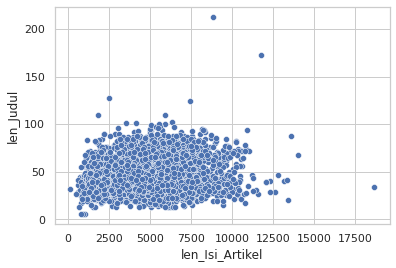

In [ ]:
sns.scatterplot(x=othertemp_comb['len_Isi_Artikel'], y=othertemp_comb['len_Judul'])

di dalam dataframe, baik tahun 2001, 2002 ataupun gabungan keduanya, korelasi antara panjang judul dan panjang artikel amat lemah. Berdasarkan hasil tersebut, dapat dikatakan bahwa analisis panjang isi artikel dengan panjang judul dapat dilakukan secara **terpisah/independen satu dengan yang lain**.
<br>

---
_The DataFrames from the articles in 2001, 2002, and the combination of both, show the correlation between title length and article length was weak. In short, the analysis of the length of title and content can be done **separately/independently of one another**._

#**Q2. Apakah ada keterkaitan antara panjang artikel dengan frekuensi kemunculan beberapa artikel yang mirip?**


**Q2. Is there any correlation between the length and the appearance of similar articles?**


## THE ANALYSIS BASED ON THE LENGTH OF THE ARTICLE

Langkah awal yang saya lakukan yaitu memvisualisasikan distribusi panjang artikel berdasarkan tanggal terbitnya. Visualisasi ini ditujukan untuk lebih mengetahui pendekatan analisis menggunakan *mean* atau *median* yang lebih baik dilakukan. Bila distribusi mendekati distribusi normal, maka penggunaan mean atau median sebagai penggambaran representasi data tidak membawa dampak segnifikan terhadap hasil analisis. Akan tetapi untuk distribusi dengan 'long tail' memerlukan analisis lebih dalam terkait nilai mean dan median pada data yang ada.<br><br>

---
_The first step was visualizing the distribution of the length of the article based on the release date. This visualization aims to obtain a better analytical approach between **mean** or **median**. When the distribution shows a normal distribution, it means that using either mean or median does not have a significant impact on the assumption of overall data. In contrast, a long-tail distribution could lead to further analysis that has to do with the mean and median of the given data._


### **Mean or Median?**

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

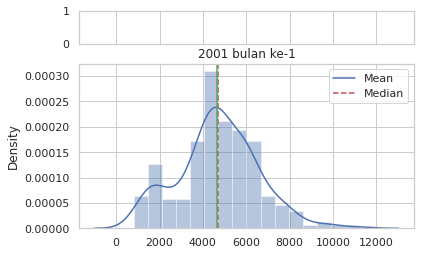

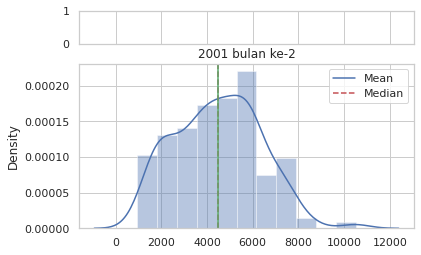

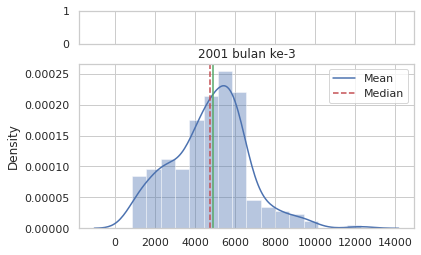

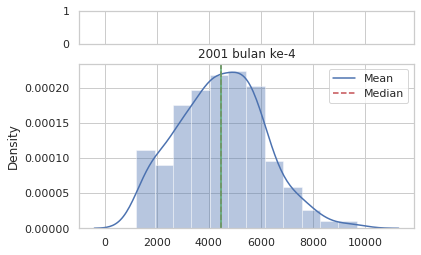

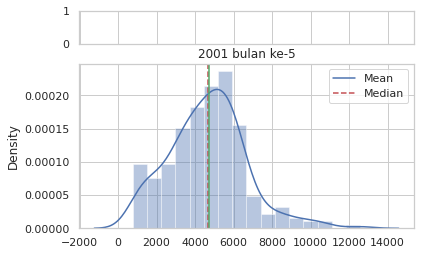

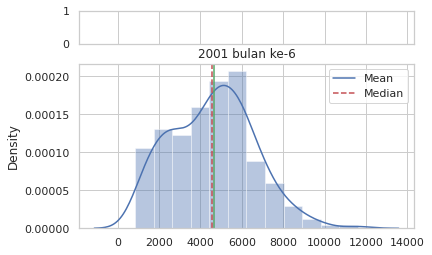

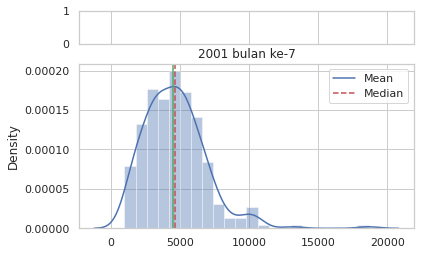

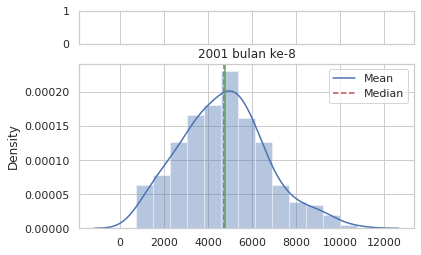

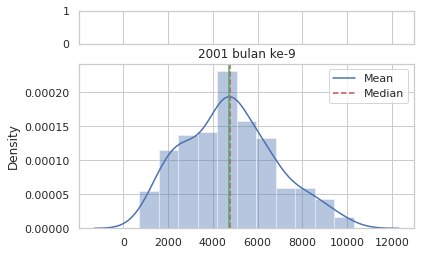

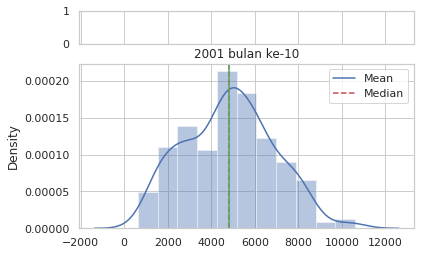

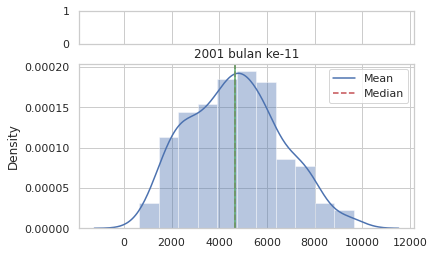

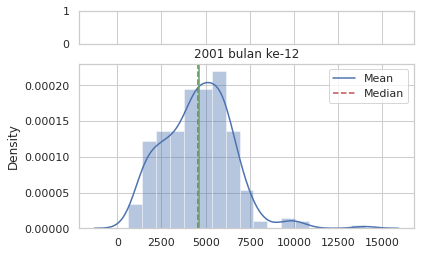

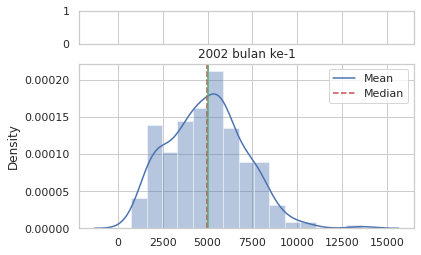

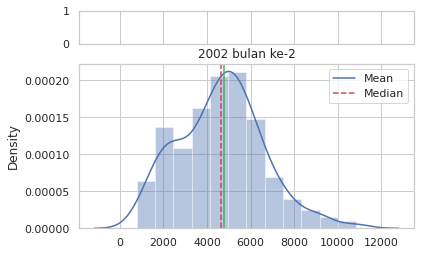

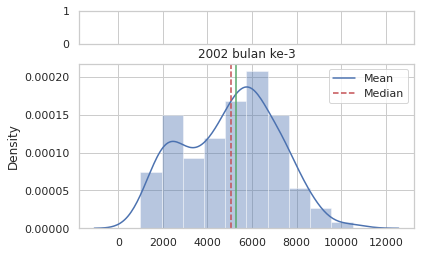

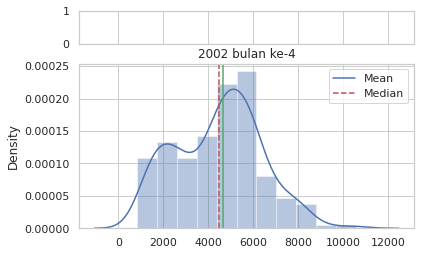

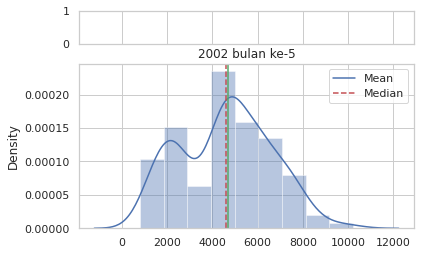

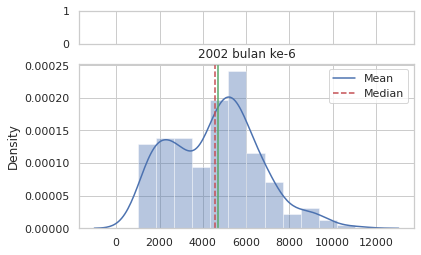

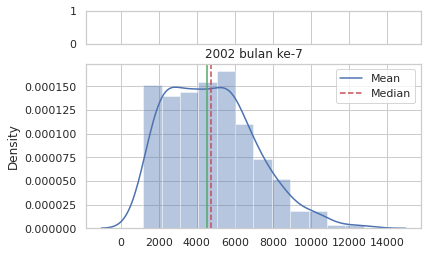

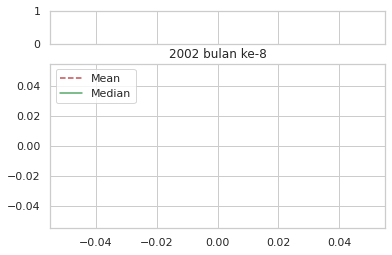

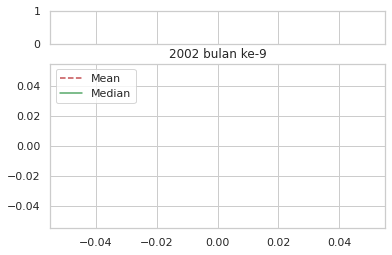

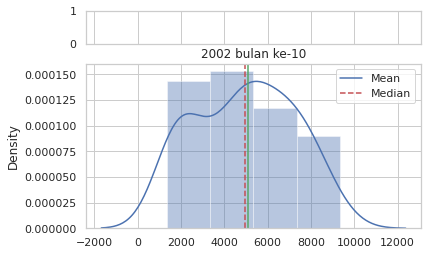

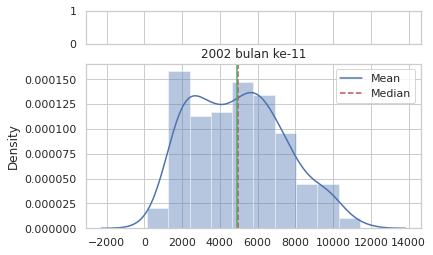

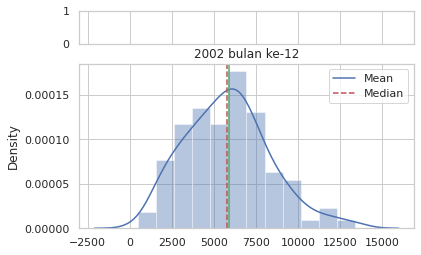

In [ ]:
for i in range(1,13):
  #print('Bulan ke-',i)
  mask = (df2001['Tanggal_Terbit'].dt.month==i)
  temp=df2001.loc[mask]
  temp=temp.loc[:,['len_Isi_Artikel']]
  #display(temp)
  f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
  mean=temp['len_Isi_Artikel'].mean()
  median=temp['len_Isi_Artikel'].median()

  temp_plot=sns.distplot(temp, ax=ax_hist)
  ax_hist.axvline(mean, color='r', linestyle='--')
  ax_hist.axvline(median, color='g', linestyle='-')
  temp_plot.set(title=('2001 bulan ke-%d'%i))
  
  plt.legend({'Mean':mean,'Median':median})

for i in range(1,13):
  #print('Bulan ke-',i)
  mask = (df2002['Tanggal_Terbit'].dt.month==i)
  temp=df2002.loc[mask]
  temp=temp.loc[:,['len_Isi_Artikel']]
  #display(temp)
  f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
  mean=temp['len_Isi_Artikel'].mean()
  median=temp['len_Isi_Artikel'].median()

  temp_plot=sns.distplot(temp, ax=ax_hist)
  ax_hist.axvline(mean, color='r', linestyle='--')
  ax_hist.axvline(median, color='g', linestyle='-')
  temp_plot.set(title=('2002 bulan ke-%d'%i))
  
  plt.legend({'Mean':mean,'Median':median})

Dari visualisasi diatas, dapat dilihat bahwa untuk distribusi tiap bulannya, baik *mean* maupun *median*nya tidak terpisah secara segnifikan. Dalam kasus ini, saya menggunakan *mean* sebagai parameter yang akan digunakan sepanjang proses analisis, mengingat distrubusi data yang *mendekati* normal.
<br>

---
_The visualization above indicates that the distribution for each month, neither the mean nor the median, is significantly separated. It also indicates that the distribution of the data is close to normal. Thus, I used the mean as the parameter during the analysis process._

NOTE: Perlu diingat bahwa pada tahun 2002, tidak tersedia data untuk bulan Agustus dan September, sehingga perlu dihilangkan pada analisis nantinya.
<br>

---
_Note: The data for August and September in 2002 were not available, so it needs to be omitted from later analysis._

### **Mean Panjang Artikel**

In [ ]:
lenartikel_2001=df2001.loc[:,['len_Isi_Artikel']]
lenartikel_2001.index=df2001['Tanggal_Terbit']  #dataframe 'lenartikel_2001' berisi jumlah karakter pada tiap isi artikel tahun 2001 dengan tanggal sebagai indexnya

lenartikel_2001_mean=lenartikel_2001.resample('M').mean()  #mencari rata-rata untuk semua record dengan index/tanggal yang sama, dan memasukan kedalam dataframe baru

lenartikel_2002=df2002.loc[:,['len_Isi_Artikel']]
lenartikel_2002.index=df2002['Tanggal_Terbit']  #dataframe 'lenartikel_2002' berisi jumlah karakter pada tiap isi artikel tahun 2002 dengan tanggal sebagai indexnya

lenartikel_2002_mean=lenartikel_2002.resample('M').mean()  #mencari rata-rata untuk semua record dengan index/tanggal yang sama, dan memasukan kedalam dataframe baru

display(lenartikel_2001_mean.describe())
display(lenartikel_2002_mean.describe())

,len_Isi_Artikel
count,12.000000
mean,4653.488865
std,112.416809
min,4463.835206
25%,4572.926397
50%,4662.521552
75%,4722.618640
max,4830.780669


,len_Isi_Artikel
count,10.000000
mean,4871.623713
std,381.968694
min,4462.129707
25%,4609.523598
50%,4845.655027
75%,4962.332223
max,5799.029126


untuk mengetahui perbandingan panjang artikel sepanjang 2001 hingga 2002 lebih jelas, saya mencoba untuk membuat bar-plot dan perbandingan korelasinya tiap tahun.
<br><br>

---
_For a better understanding of the length of articles in 2001 compared to 2002, I tried to make a bar-plot and correlation table for each year._


In [ ]:
ls2001_mean=[]
for i in list(lenartikel_2001_mean.values):
  ls2001_mean.append(i[0])

ls2002_mean=[]
for i in list(lenartikel_2002_mean.values):
  ls2002_mean.append(i[0])

meanpermonth=pd.DataFrame({'Month':['Jan','Feb','Mar','Apr','Mei','Jun','Jul','Aug','Sept','Oct','Nov','Des'],
                           '2001':ls2001_mean,
                           '2002':ls2002_mean})
display(meanpermonth)

,Month,2001,2002
0,Jan,4701.444030,4954.573077
1,Feb,4487.159184,4649.781893
2,Mar,4748.338710,5038.121849
3,Apr,4463.835206,4462.129707
4,Mei,4649.599206,4596.104167
5,Jun,4573.969811,4560.268657
6,Jul,4664.780142,4749.185053
7,Aug,4714.045283,NaN
8,Sept,4777.855019,NaN
9,Oct,4830.780669,4942.125000


In [ ]:
barplot_meanpermonth=pd.melt(meanpermonth, id_vars=['Month'], value_vars=['2001','2002'], var_name='Year', value_name='Mean of articles length')
barplot_meanpermonth.head()

,Month,Year,Mean of articles length
0,Jan,2001,4701.444030
1,Feb,2001,4487.159184
2,Mar,2001,4748.338710
3,Apr,2001,4463.835206
4,Mei,2001,4649.599206


### **Correlation length of article per month**
<a id='korelasi_perbulan'></a>

[Text(0.5, 1.0, 'Correlation of means for 2001 and 2002 (August and October excluded)')]

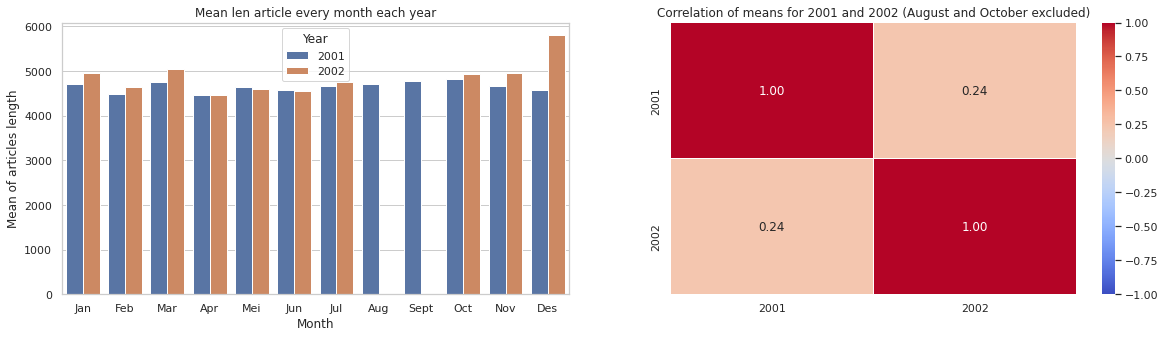

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
mean_bar=sns.barplot(x='Month', y='Mean of articles length', hue='Year', data=barplot_meanpermonth)
mean_bar.set(title="Mean len article every month each year")

plt.subplot(1,2,2)
df_for_corr=meanpermonth.iloc[:7,:]
df_for_corr=df_for_corr.append(meanpermonth.iloc[9:,:])
mean_coor = sns.heatmap(round(df_for_corr.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1)
mean_coor.set(title="Correlation of means for 2001 and 2002 (August and October excluded)")

Korelasi rata-rata panjang artikel perbulan selama 2 tahun cukup kecil secara keseluruhan, akan tetapi dapat dilihat bahwa pada bulan Desember 2002 terdapat lonjakan rata-rata panjang artikel. Ada kemungkinan bahwa Desember 2002 merupakan anomali yang membuat korelasi antar tahun menjadi lemah.<br><br>
Untuk mengetahui apakah lonjakan ini cukup segnifikan, saya mencoba untuk menghilangkan bulan Desember dari tabel, sehingga diperoleh hasil :<br><br>

---
_The correlation of the average length of articles per month in 2 years is pretty small overall. However, in December 2002, there was a spike in the average length of the articles. It is possible that in December 2002, there was an anomaly that made the correlation weak between years._

_To find out if this spike was significant enough, I tried to exclude December from the equation so that the result was:_

[Text(0.5, 1.0, 'Corr means (August, October and December excluded)')]

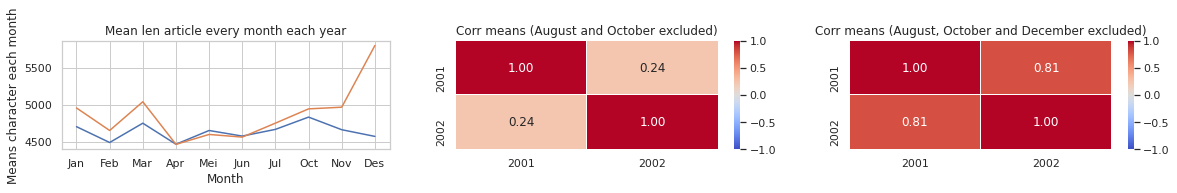

In [ ]:
plt.figure(figsize=(20,2))
plt.subplot(1,3,1)
line_plt=sns.lineplot(x='Month', y='2001',data=df_for_corr, sort=False)
line_plt=sns.lineplot(x='Month', y='2002',data=df_for_corr, sort=False)
line_plt.set(title="Mean len article every month each year", ylabel='Means character each month')

plt.subplot(1,3,2)
df_for_corr1=meanpermonth.iloc[:7,:]
df_for_corr1=df_for_corr1.append(meanpermonth.iloc[9:,:]) #dataframe tanpa bulan agustus dan september
mean_coor = sns.heatmap(round(df_for_corr1.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1)
mean_coor.set(title="Corr means (August and October excluded)")

plt.subplot(1,3,3)
df_for_corr2=meanpermonth.iloc[:7,:]
df_for_corr2=df_for_corr2.append(meanpermonth.iloc[9:11,:]) #dataframe tanpa bulan agustus, september, desember
mean_coor_nodes = sns.heatmap(round(df_for_corr2.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1)
mean_coor_nodes.set(title="Corr means (August, October and December excluded)")

<a id='barplot_mean'></a>Jika bulan Desember diabaikan, maka korelasi panjang artikel kedua tahun tersebut **bertambah** pesat dari 0.24 menjadi 0.81.<br>
Selanjutnya, saya mencoba mencaritahu apakah 'Desember' hanya satu-satunya "anomali" atau ada data dibulan lainnya yang memiliki pengaruh yang serupa.<br><br>

---
_Without the data in December, the correlation between the length of the articles for both years increases rapidly from 0.24 to 0.81.<br>
 Next, I tried to discover if 'December' was the only "anomaly" or was it another month's data that had a similar effect._

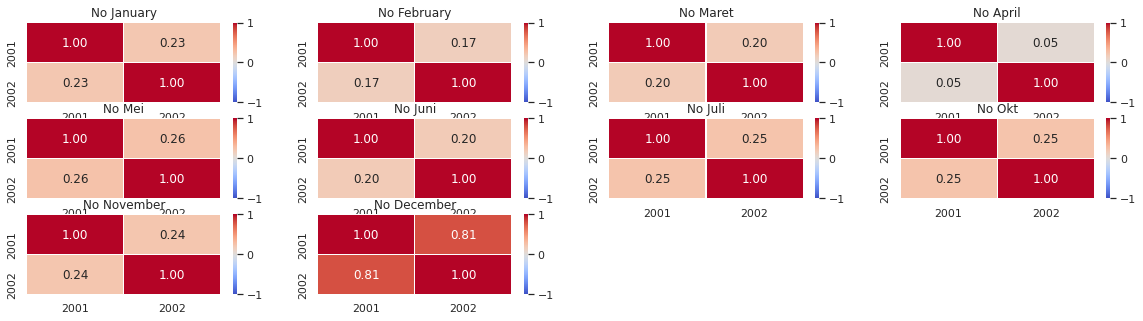

In [ ]:
plt.figure(figsize=(20,5))

plt.subplot(3,4,1)
#No January
temp_corr=meanpermonth.iloc[:7,:]
temp_corr=temp_corr.append(meanpermonth.iloc[9:,:])
temp_corr=temp_corr[temp_corr.Month != 'Jan']
sns.heatmap(round(temp_corr.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1).set(title="No January")

plt.subplot(3,4,2)
#No February
temp_corr=meanpermonth.iloc[:7,:]
temp_corr=temp_corr.append(meanpermonth.iloc[9:,:])
temp_corr=temp_corr[temp_corr.Month != 'Feb']
sns.heatmap(round(temp_corr.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1).set(title="No February")

plt.subplot(3,4,3)
#No Maret
temp_corr=meanpermonth.iloc[:7,:]
temp_corr=temp_corr.append(meanpermonth.iloc[9:,:])
temp_corr=temp_corr[temp_corr.Month != 'Mar']
sns.heatmap(round(temp_corr.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1).set(title="No Maret")

plt.subplot(3,4,4)
#No April
temp_corr=meanpermonth.iloc[:7,:]
temp_corr=temp_corr.append(meanpermonth.iloc[9:,:])
temp_corr=temp_corr[temp_corr.Month != 'Apr']
sns.heatmap(round(temp_corr.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1).set(title="No April")

plt.subplot(3,4,5)
#No Mei
temp_corr=meanpermonth.iloc[:7,:]
temp_corr=temp_corr.append(meanpermonth.iloc[9:,:])
temp_corr=temp_corr[temp_corr.Month != 'Mei']
sns.heatmap(round(temp_corr.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1).set(title="No Mei")

plt.subplot(3,4,6)
#No Juni
temp_corr=meanpermonth.iloc[:7,:]
temp_corr=temp_corr.append(meanpermonth.iloc[9:,:])
temp_corr=temp_corr[temp_corr.Month != 'Jun']
sns.heatmap(round(temp_corr.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1).set(title="No Juni")

plt.subplot(3,4,7)
#No Juli
temp_corr=meanpermonth.iloc[:7,:]
temp_corr=temp_corr.append(meanpermonth.iloc[9:,:])
temp_corr=temp_corr[temp_corr.Month != 'Jul']
sns.heatmap(round(temp_corr.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1).set(title="No Juli")

plt.subplot(3,4,8)
#No Okt
temp_corr=meanpermonth.iloc[:7,:]
temp_corr=temp_corr.append(meanpermonth.iloc[9:,:])
temp_corr=temp_corr[temp_corr.Month != 'Oct']
sns.heatmap(round(temp_corr.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1).set(title="No Okt")

plt.subplot(3,4,9)
#No November
temp_corr=meanpermonth.iloc[:7,:]
temp_corr=temp_corr.append(meanpermonth.iloc[9:,:])
temp_corr=temp_corr[temp_corr.Month != 'Nov']
sns.heatmap(round(temp_corr.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1).set(title="No November")

plt.subplot(3,4,10)
df_for_corr2=meanpermonth.iloc[:7,:]
df_for_corr2=df_for_corr2.append(meanpermonth.iloc[9:11,:]) #dataframe tanpa bulan agustus, september, desember
mean_coor_nodes = sns.heatmap(round(df_for_corr2.corr(),2), annot=True, cmap="coolwarm",fmt='.2f',linewidths=.05,vmin=-1,vmax=1).set(title="No December")

Dari perbandingan data mean panjang artikel untuk tahun 2001 dan 2002 selama 10 bulan (dengan asumsi Agustus dan September selalu tidak disertakan), diperoleh hasil bahwa perubahan korelasi yang cukup segnifikan **hanya** terjadi bila bulan Desember dihilangkan dari persamaaan.
<br><br>

---
_The comparison between the means from the length of the article in 2001 and 2002 for 10 months (assuming that August and September were always excluded), it is found that a significant change in the correlation only occurs when December is omitted from the equation._

### **Identifikasi dan Analisis Anomali Data Panjang Artikel**
Identification and analysis of anomaly related to the length of the article

Saya mencoba untuk mendapatkan gambaran tentang data outlier dengan menggunakan box-plot
<br><br>

---
_I tried to get an overview of the outlier data using a box-plot_

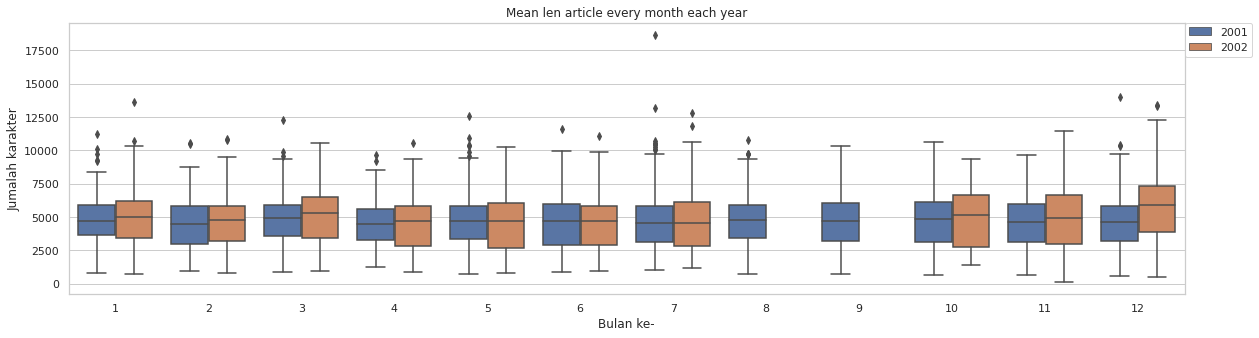

In [ ]:
boxplot_lenartikel_allyear=lenartikel_2001
boxplot_lenartikel_allyear=boxplot_lenartikel_allyear.append(lenartikel_2002)
boxplot_lenartikel_allyear['year'] = boxplot_lenartikel_allyear.index.year
#display(boxplot_lenjudul)

plt.figure(figsize=(20,5))
plt.subplot(1,1,1)
mean_bar=sns.boxplot(x=boxplot_lenartikel_allyear.index.month , y=boxplot_lenartikel_allyear['len_Isi_Artikel'], hue=boxplot_lenartikel_allyear['year'])
mean_bar.set(title="Mean len article every month each year")
mean_bar.set(xlabel='Bulan ke-', ylabel='Jumalah karakter')
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

Meskipun data yang paling berpengaruh di korelasi antar tahun berada di bulan Desember, ternyata _outlier_ terbesar justru terletak di bulan Juli (bulan ke-7).<br>

Dari analisa korelasi sebelumnya diketahui bahwa bulan Desember merupakan anomali. Selanjutnya saya akan melakukan identifikasi *outlier* di bulan Desember untuk mengetahui letak anomali. Visualisasi box-plot untuk panjang artikel di bulan Desember adalah seperti berikut :<br><br>

---

_Although the most influential data on the correlation between years is in December, it turns out that the most noticeable outlier data are in July (7th month)._ 

_From the previous correlation analysis, it concluded that December is an anomaly. Next, I will identify the outliers in December to determine the exact anomaly. The box-plot visualization for the article length in December is as follows:_

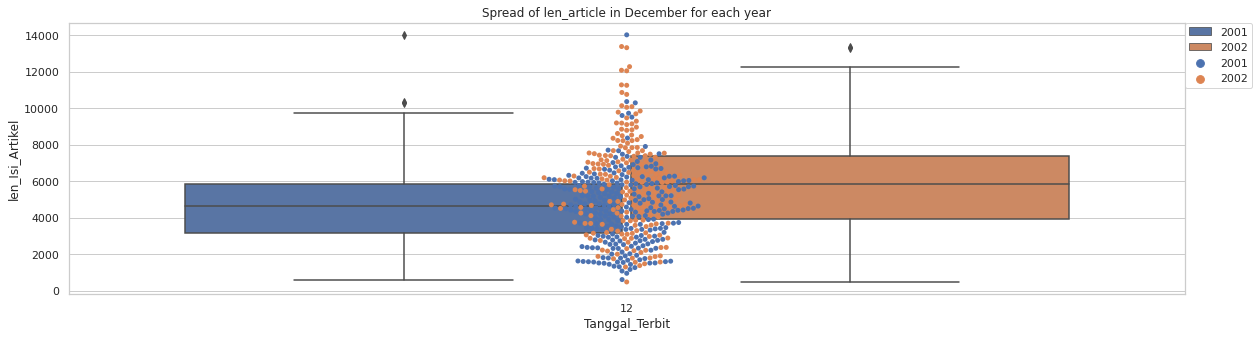

In [ ]:
boxplot_lenartikel2001=lenartikel_2001.iloc[(lenartikel_2001.index.month)==12,:]
#display(boxplot_lenartikel2001.describe())
boxplot_lenartikel2002=lenartikel_2002.iloc[(lenartikel_2002.index.month)==12,:]
#display(boxplot_lenartikel2002.describe())

boxplot_lenartikel=boxplot_lenartikel2001
boxplot_lenartikel=boxplot_lenartikel.append(boxplot_lenartikel2002)
boxplot_lenartikel['year'] = boxplot_lenartikel.index.year


plt.figure(figsize=(20,5))
plt.subplot(1,1,1)
mean_box=sns.boxplot(x=boxplot_lenartikel.index.month , y='len_Isi_Artikel', hue='year', data=boxplot_lenartikel)
mean_box.set(title="Spread of len_article in December for each year")
mean_box.set(xlabel='Bulan ke-', ylabel='Jumalah karakter')
mean_box=sns.swarmplot(x=boxplot_lenartikel.index.month , y='len_Isi_Artikel', hue='year', data=boxplot_lenartikel)
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

Dari box-plot tersebut, kita tahu bahwa *outlier tahun 2001* memiliki nilai diatas $\approx$ 9,800, sementara *outlier tahun 2002* memiliki nilai diatas $\approx$ 12,200. <br>
Analisa selanjutnya dengan mengidentifikasi artikel apa saja yang termasuk dalam *outlier*.<br><br>

---
_From the box-plot, we know that the 2001 outliers had a value above ≈ 9,800, while the 2002 outliers had a value above ≈ 12,200. The next step is identifying which articles are the outliers._

In [ ]:
print('Tahun 2001')
getoutliersDes2001= df2001.loc[df2001['len_Isi_Artikel']>9800]
getoutliersDes2001=getoutliersDes2001[getoutliersDes2001['Tanggal_Terbit'].dt.month==12]
display(getoutliersDes2001)
display(getoutliersDes2001.describe())

print('\nTahun 2002')
getoutliersDes2002= df2002.loc[df2002['len_Isi_Artikel']>12200]
getoutliersDes2002=getoutliersDes2002[getoutliersDes2002['Tanggal_Terbit'].dt.month==12]
display(getoutliersDes2002)
display(getoutliersDes2002.describe())

Tahun 2001


,Index_artikel,Isi_Artikel,Judul_Artikel,Tanggal_Terbit,len_Isi_Artikel,len_Judul
3000,100,ulasan minggu ini mau tak mau bersifat amat mi...,"ANALISIS EKONOMI SJAHRIR Kebijakan Mikro, d...",2001-12-10,10293,68
3043,143,transaksi indomobil merupakan puncak es dari k...,"Ketidakwajaran Indomobil dan ""Recovery Rate"" H...",2001-12-18,10362,74
3158,258,oleh ignas kledenpendidikan nasional di indone...,RENUNGAN AKHIR TAHUN Kekosongan Individu da...,2001-12-31,14019,67


,Index_artikel,len_Isi_Artikel,len_Judul
count,3.000000,3.000000,3.000000
mean,167.000000,11558.000000,69.666667
std,81.688432,2131.567733,3.785939
min,100.000000,10293.000000,67.000000
25%,121.500000,10327.500000,67.500000
50%,143.000000,10362.000000,68.000000
75%,200.500000,12190.500000,71.000000
max,258.000000,14019.000000,74.000000



Tahun 2002


,Index_artikel,Isi_Artikel,Judul_Artikel,Tanggal_Terbit,len_Isi_Artikel,len_Judul
987,124,pengantar redaksinnkrisis multidimensi yang me...,Kreatif Menguras Kocek Rakyat,2002-12-20,12277,29
1017,154,oleh j sunarkannungkapan iman allah menyertai ...,Natal Berprihatin atas Era Neoliberalisme,2002-12-24,13316,41
1067,204,oleh ignas kledennnsecara berurutan akhir tahu...,Arkeologi Perdamaian,2002-12-31,13380,20


,Index_artikel,len_Isi_Artikel,len_Judul
count,3.000000,3.000000,3.000000
mean,160.666667,12991.000000,30.000000
std,40.414519,619.169605,10.535654
min,124.000000,12277.000000,20.000000
25%,139.000000,12796.500000,24.500000
50%,154.000000,13316.000000,29.000000
75%,179.000000,13348.000000,35.000000
max,204.000000,13380.000000,41.000000


Terdapat 3 artikel *outlier* untuk masing-masing tahun dibulan Desember. Bila dilihat dari tanggal terbitnya, ketiganya (untuk masing-masing tahun) tidak diterbitkan pada tanggal yang sama.<br><br>

**Asumsi sementara** yang dapat disampaikan adalah ketiga artikel ini memiliki topik yang cukup penting/menarik/unik sehingga memiliki isi lebih panjang dibandingkan artikel lainnya depanjang bulan Desember. Hal ini juga dapat diartikan bahwa bulan Desember bertindak sebagai *trigger* sehingga menyebabkan pola yang tidak konsisten antar tahun 2001 dengan2002 (dengan asumsi agustus dan september tidak disertakan)<br><br>
Untuk membuktikan pernyataan diatas, saya mencoba melakukan analisis dengan menggunakan *cosine similarity* antar artikel di bulan Desember.<br><br>

---
_There are 3 outlier articles for each year in December. By looking at the publication date, those three (for each year) were not published on the same date._

_The provisional assumption that can be conveyed is that these three articles have sufficiently important/interesting/unique topics so that they have longer contents than other articles in December. It can also imply that December was a trigger causing an inconsistent pattern between 2001 and 2002 (assuming August and September were not included)_

_To prove the above statement, I tried to analyze the cosine similarity between articles in December._

## COSINE SIMILARITY ANALYSIS

###Analisis Perbulan Desember
Analysis in December

Dari analisis yang diperoleh sebelumnya, kumpulan artikel pada bulan Desember memiliki kemungkinan bertindak sebagai pemegang 'kunci' yang menyebabkan keteraturan panjang artikel sepanjang tahun 2001 dan 2002 menjadi saling tidak berkorelasi.

Pada bagian ini saya akan melakukan analisis artikel outlier pada bulan Desember 2001 dan 2002 terhadap seluruh artikel pada bulan tersebut.<br><br>

---
_From the analysis obtained previously, the collection of articles in December is likely to play a big role in causing the regularity of article length throughout 2001 and 2002 to be not correlated._

_In this part, I compared the outlier articles (in December 2001 and 2002) to all articles in those months._

#### **DESEMBER 2001**

In [ ]:
#3 artikel outlier pada bulan Desember 2001
display(getoutliersDes2001)

,Index_artikel,Isi_Artikel,Judul_Artikel,Tanggal_Terbit,len_Isi_Artikel,len_Judul
3000,100,ulasan minggu ini mau tak mau bersifat amat mi...,"ANALISIS EKONOMI SJAHRIR Kebijakan Mikro, d...",2001-12-10,10293,68
3043,143,transaksi indomobil merupakan puncak es dari k...,"Ketidakwajaran Indomobil dan ""Recovery Rate"" H...",2001-12-18,10362,74
3158,258,oleh ignas kledenpendidikan nasional di indone...,RENUNGAN AKHIR TAHUN Kekosongan Individu da...,2001-12-31,14019,67


#####**_Cosine similarity_ antar ketiga artikel** dilakukan dengan memperhitungkan kemunculan token pada masing-masing artikel. Kemunculan token akan direpresentasikan kedalam vektor multidimensi yang kemudian akan dicari sudutnya dengan pendekatan _cosine similarity_. Besar sudut antar vektor mengindikasikan kemiripan antar artikel.<br><br>

---
_The Cosine similarity calculation between the three articles was by measuring the appearance of tokens in each article. The token will be represented as a multidimensional vector. The angles between factors represent the Cosine similarity value and also indicate the similarities between articles._<br><br>

_Preprocessing_ sebelum melakukan perhitungan *cosine similarity* yaitu dengan menghilangkan **stop words** dengan korpus bahasa Indonesia. Disini saya menggunakan _library **nltk**_ untuk kemudian ditambahkan ke *stop_words* default milik *CountVectorizer*. Dengan tambahan _stop words_ ini membantu untuk mereduksi feature per artikelnya.<br><br>

---
_Preprocessing is a principal stage before Cosine similarity calculation in which the stop words removal was included. I used the nltk library to add default Indonesian stop words from CountVectorizer. The addition of stop words is to help to reduce the feature._

In [ ]:
from sklearn.feature_extraction import text 

listStopword =  set(nltk.corpus.stopwords.words('indonesian'))
stop_words = text.ENGLISH_STOP_WORDS.union(listStopword)

vect1 = CountVectorizer(binary=True, max_features=None)
matrix1 = vect1.fit_transform(getoutliersDes2001['Isi_Artikel'])

attribute_names1=vect1.get_feature_names()
print('Feature dengan Tanpa Tambahan nltk: ',len(attribute_names1))

bow_matrix_nonltk=pd.DataFrame(matrix1.toarray(),columns=attribute_names1)
display(bow_matrix_nonltk)

vect = CountVectorizer(binary=True, max_features=None, stop_words=stop_words)
matrix = vect.fit_transform(getoutliersDes2001['Isi_Artikel'])

attribute_names=vect.get_feature_names()
print('Feature dengan Tambahan nltk: ',len(attribute_names))

bow_matrix_outlier=pd.DataFrame(matrix.toarray(),columns=attribute_names)
display(bow_matrix_outlier)

Feature dengan Tanpa Tambahan nltk:  1451


,abnormalitas,account,ada,adalah,adanya,adil,advantage,agar,agung,agus,ahistoris,ahli,aidin,air,akal,akan,akarakarnya,akbar,akhir,akhirnya,akibat,akses,aktif,aktivitas,akuntabel,akuntabilitas,alami,alasan,alat,alfred,almahrum,aman,amat,amatlah,ambon,ami,anak,anakanak,analis,analisa,...,ulasan,umstellung,umwertung,und,undangan,unfair,unik,unsur,untuk,upaya,uraian,usaha,usahausaha,usul,utama,utang,uu,valid,validitas,venture,versi,vom,vulgar,wajar,wajib,wakil,waktu,walfaizinnn,warga,waspadalah,watak,weighted,wewenang,wewenangnya,win,wiryawan,yaitu,yang,zaman,ze
0,0,1,1,1,1,0,0,1,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,1,1,1,0
1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,1,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0
2,0,0,1,1,1,0,0,1,0,1,1,1,0,1,0,1,1,1,0,1,1,0,1,0,1,0,1,1,1,1,1,0,1,0,1,0,1,1,0,1,...,0,1,1,1,1,0,1,1,1,0,1,1,0,1,0,1,1,0,0,0,1,1,1,0,0,0,1,0,1,1,1,0,1,1,0,0,1,1,0,1


Feature dengan Tambahan nltk:  1135


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,abnormalitas,account,adil,advantage,agung,agus,ahistoris,ahli,aidin,air,akal,akarakarnya,akbar,akibat,akses,aktif,aktivitas,akuntabel,akuntabilitas,alami,alasan,alat,alfred,almahrum,aman,ambon,ami,anak,anakanak,analis,analisa,aneh,anggaran,anggota,apbn,apbndua,arah,argumen,article,artifisial,...,turunan,uang,ujian,ulang,ulasan,umstellung,umwertung,und,undangan,unfair,unik,unsur,upaya,uraian,usaha,usahausaha,usul,utama,utang,uu,valid,validitas,venture,versi,vom,vulgar,wajar,wajib,wakil,walfaizinnn,warga,waspadalah,watak,weighted,wewenang,wewenangnya,win,wiryawan,zaman,ze
0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,1,0
1,1,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,0,1,1,1,1,1,0,1,0,1,1,0,1,0,1,1,0,0,1,0,0,0,...,1,1,1,1,0,1,1,1,1,0,1,1,0,1,1,0,1,0,1,1,0,0,0,1,1,1,0,0,0,0,1,1,1,0,1,1,0,0,0,1


Similarity antar ketiga artikel :

---
_The similarity between 3 articles_ :

In [ ]:
pd.set_option('display.max_rows', 15)

simOutlierDes2001=cosine_similarity(bow_matrix_outlier)

similarity_df=pd.DataFrame(data=simOutlierDes2001[:,:],columns=(i for i in range(len(simOutlierDes2001))))
similarity_df.index=getoutliersDes2001['Index_artikel']
similarity_df.columns=getoutliersDes2001['Index_artikel']
display(similarity_df)

Index_artikel,100,143,258
Index_artikel,,,
100,1.000000,0.169376,0.142178
143,0.169376,1.000000,0.128788
258,0.142178,0.128788,1.000000


Bila menggunakan asumsi awal bahwa threshold cosine similarity adalah 0.12, maka ketiga artikel threshold pada Desember 2001 memiliki kemiripan yang cukup segnifikan<br><br>

---
_By using the initial assumption (threshold=0.12), it can be concluded that the outliers articles have a significant similarity._

#####**_Cosine similarity_ masing-masing ketiga artikel terhadap seluruh artikel di Desember 2001**

_Cosine similarity from 3 (outliers) articles to other articles in December 2001_

Preprocessing yang dilakukan sama dengan sebelumnya, hanya saja kali ini saya menggunakan dataframe yang memuat 260 artikel yang terbit di Desember 2001. <br><br>

---

_Preprocessing is identical as previous, but this time I use a dataframe that contains 260 articles published in December 2001._

In [ ]:
Des2001=df2001[df2001['Tanggal_Terbit'].dt.month==12]
Des2001.head()

,Index_artikel,Isi_Artikel,Judul_Artikel,Tanggal_Terbit,len_Isi_Artikel,len_Judul
2900,0,tingginya kenaikan hargaharga barang kebutuhan...,"Inflasi November 1,71 Persen Kumulatif Ekspo...",2001-12-01,5206,65
2901,1,saksofonis embong rahardjo meninggal dunia dal...,Embong Rahardjo Meninggal,2001-12-01,4088,25
2902,2,something in the way she movesattracts me like...,"""In Memoriam"" George Harrison",2001-12-01,4634,29
2903,3,penangkapan hutomo mandala putra alias tommy s...,Kepala Polri tentang Penangkapan Tommy Jadik...,2001-12-01,6397,88
2904,4,setelah melalui perdebatan panjang dan kontrov...,PT Semen Padang Berdiri Sendiri Demikian Jug...,2001-12-01,4618,63


In [ ]:
pd.set_option('display.max_rows', 2)
vect = CountVectorizer(binary=True, max_features=None, stop_words=stop_words)
matrix = vect.fit_transform(Des2001['Isi_Artikel'])

attribute_names=vect.get_feature_names()
print('Features untuk semua artikel Desember 2001 :',len(attribute_names))

bow_matrix=pd.DataFrame(matrix.toarray(),columns=attribute_names)
display(bow_matrix)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Features untuk semua artikel Desember 2001 : 17102


,aa,aai,ab,abad,abadi,abang,abay,abd,abdi,abdu,abdul,abdulgani,abdullah,abdullahpara,abdurahman,abdurrab,abdurrahman,abel,abg,abi,abidin,abidinsampai,abilowo,abimanyu,abk,abn,abnormalitas,abolisi,aborsi,aborsikasus,abri,abs,absennya,abstainbamus,abt,abu,abuabu,abualhassan,abualkhair,abunyakini,...,yus,yusgiantoro,yusril,yusrilditanyakan,yussac,yustisia,yusuf,yusup,yuwono,yuyun,zabul,zacarias,zaeef,zaenie,zahir,zaim,zainal,zainie,zainiesecara,zainuddin,zakat,zakatnya,zakir,zakirinformasi,zaman,zamannya,zat,ze,zee,zero,ziaki,ziarah,zinni,zinninn,zona,zuhir,zul,zulkarnaen,zulkifli,zz
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Dengan menggunakan asumsi awal, bahwa artikel yang memiliki tema yang sama memiliki cosine similaroty $\approx$ 0.12 saya mencoba untuk menampilkan semua artikel yang memiliki cosine similarity > 0.12 terhadap ketiga artikel outlier.<br><br>
**note:** Outlier matrix pada index_artikel [100,143,258]<br><br>

---

_By using the initial assumption (threshold=0.12), I try to find articles with cosine similarity> 0.12 in the three outlier articles._ 
<br><br>
_**note:** index_artikel for Outliers were [100,143,258]_

In [ ]:
pd.set_option('display.max_rows', 15)

artikel_i=[]
artikel_j=[]

artikel_mirip_outlier=[]
for i in range(bow_matrix.shape[0]):
  for j in range(bow_matrix.shape[0]):
    simDes2001=cosine_similarity(bow_matrix.iloc[[i,j]])
    if(simDes2001[0][1] > 0.12 and i!=j):
      artikel_i.append(str(i))
      artikel_j.append(str(j))

      if(i==100 or i == 143 or i == 258):
        pasangan=[i,j,simDes2001[0][1]]
        artikel_mirip_outlier.append(pasangan)
      
print('jumlah pasangan artikel dengan kemiripan diatas 0.12 :',len(artikel_i))
print('jumlah pasangan artikel dengan kemiripan diatas 0.12 dengan artikel ourlier :',len(artikel_mirip_outlier))

jumlah pasangan artikel dengan kemiripan diatas 0.12 : 3510
jumlah pasangan artikel dengan kemiripan diatas 0.12 dengan artikel ourlier : 77


Dari data diatas diketahui bahwa diantara total $260^{2}=67600$ pasang, terdapat 3510 pasang artikel dengan kemiripan diatas 0.12 dimana 77 diantaranya merupakan kemiripan dengan 3 artikel outlier. 77 pasang tersebut dapat dilihat pada list dibawah dengan ketentuan<br><br>
[**_index_artikel_outlier_**, **_index_artikel_pasangan_**, **_cosine_similarity_**]
<br><br>

---
_The data show that among the total 2602 = 67600 pairs, there were 3510 pairs of articles with similarities above 0.12. in which 77 are similar to 3 outlier articles. All 77 pairs ware shown in the list below with sequence as follow :_

[**_outlier_article_index_**, **_couple_article_index_**, **_cosine_similarity_**]

In [ ]:
display(artikel_mirip_outlier[:5])
print('...')

[[100, 4, 0.22824559600582012],
 [100, 20, 0.20739696828785087],
 [100, 25, 0.18292793968905102],
 [100, 39, 0.16276743112872766],
 [100, 42, 0.1312337323637542]]

...


Dari semua list diatas, saya mencoba untuk melihat artikel yang diterbitkan pada hari yang sama dengan _outliers_.<br><br>

---
_From the given list, I try to identify articles that were published on the same day as the outliers._

In [ ]:
recordinsameday=0
i100=0
i143=0
i258=0
for i in artikel_mirip_outlier:
  record_outlier=Des2001[Des2001['Index_artikel']==i[0]]
  record=Des2001[Des2001['Index_artikel']==i[1]]
  if (record_outlier['Tanggal_Terbit'].values == record['Tanggal_Terbit'].values):
    print(record_outlier['Tanggal_Terbit'].values,' : ',record['Tanggal_Terbit'].values, ' => ',i)
    if (i[0]==100):
      i100+=1
    elif (i[0]==143):
      i143+=1
    elif (i[0]==258):
      i258+=1
    recordinsameday+=1
print('Jumlah artikel dengan similarity > 0.12 yang terbit pada hari yang sama dengan artikel outlier: ',recordinsameday)
print('Jumlah artikel dihari yang sama dengan artikel index 100 : ',i100)
print('Jumlah artikel dihari yang sama dengan artikel index 143 : ',i143)
print('Jumlah artikel dihari yang sama dengan artikel index 258 : ',i258)

['2001-12-10T00:00:00.000000000']  :  ['2001-12-10T00:00:00.000000000']  =>  [100, 97, 0.18186330771716405]
['2001-12-31T00:00:00.000000000']  :  ['2001-12-31T00:00:00.000000000']  =>  [258, 254, 0.12289036095775178]
['2001-12-31T00:00:00.000000000']  :  ['2001-12-31T00:00:00.000000000']  =>  [258, 259, 0.14031335782712287]
Jumlah artikel dengan similarity > 0.12 yang terbit pada hari yang sama dengan artikel outlier:  3
Jumlah artikel dihari yang sama dengan artikel index 100 :  1
Jumlah artikel dihari yang sama dengan artikel index 143 :  0
Jumlah artikel dihari yang sama dengan artikel index 258 :  2


Untuk bulan Desember 2001, hanya terdapat 3 artikel yang memiliki kemiripan dengan outlier dan diterbitkan pada hari yang sama.

####**Kesimpulan untuk Desember 2001**
Dari total 260 artikel (dari jumlah _row_ dataset), terdapat 77 artikel ($\approx$29.61%) yang memiliki kemiripan dengan 3 artikel _outlier_. 3 artikel dari 77 artikel tersebut ($\approx$3.89%) diterbitkan pada hari yang sama.<br><br>

---
_In December 2001, only 3 articles had similarities with outliers and were published on the same day._

_**Conclusions for December 2001.**_

_Among the 260 articles, there are 77 articles (≈ 29.61%) that are similar to the 3 outlier articles. 3 of those 77 articles (3.89%) were published on the same day._

#### **DESEMBER 2002**<br>
DECEMBER 2002<br>
Untuk analisis data Desember 2002, saya melakukan tahapan yang sama seperti yang sebelumnya dilakukan untuk data Desember 2001.<br><br>

---
_Data analysis on December 2002, I took the same steps as previously done for the December 2001 data._

In [ ]:
#3 artikel outlier pada bulan Desember 2002
display(getoutliersDes2002)

,Index_artikel,Isi_Artikel,Judul_Artikel,Tanggal_Terbit,len_Isi_Artikel,len_Judul
987,124,pengantar redaksinnkrisis multidimensi yang me...,Kreatif Menguras Kocek Rakyat,2002-12-20,12277,29
1017,154,oleh j sunarkannungkapan iman allah menyertai ...,Natal Berprihatin atas Era Neoliberalisme,2002-12-24,13316,41
1067,204,oleh ignas kledennnsecara berurutan akhir tahu...,Arkeologi Perdamaian,2002-12-31,13380,20


#####**The Cosine similarity calculation between the three (outliers) articles**

In [ ]:
from sklearn.feature_extraction import text 

listStopword =  set(nltk.corpus.stopwords.words('indonesian'))
stop_words = text.ENGLISH_STOP_WORDS.union(listStopword)
vect = CountVectorizer(binary=True, max_features=None, stop_words=stop_words)
matrix = vect.fit_transform(getoutliersDes2002['Isi_Artikel'])

attribute_names=vect.get_feature_names()
print('Feature dengan Tambahan nltk: ',len(attribute_names))

bow_matrix_outlier=pd.DataFrame(matrix.toarray(),columns=attribute_names)
display(bow_matrix_outlier)

Feature dengan Tambahan nltk:  1569


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,abad,abdi,aceh,adannrezim,adil,adu,affairsceia,agama,agen,agrarian,agung,agustus,ahli,air,ajakan,akademis,akar,akbar,akhirakhir,akibat,akibatnya,akses,aksi,akta,aktivitas,aktor,aktualisasi,akui,ala,alam,alasan,alfridel,alih,alimenghadang,allah,allahnnpengalaman,allahu,alternatif,ama,amannya,...,turun,turunnya,uang,ubahnya,uji,ukur,ukuran,undangundang,unggul,ungkapan,unik,unsur,untung,uraian,usaha,utama,utang,utaraselatan,violent,walet,wali,wanandi,wangenanbesar,warga,warganndi,warlords,warna,washington,waswas,watak,welfarestate,wewenang,wilayah,wiradinatannpengerukan,wujudnya,ya,yohanes,york,yudikatif,zaman
0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,1,1,1,1,0,1,0,0,0,0,1,0,...,1,0,1,0,1,0,1,1,0,0,1,0,1,0,1,1,1,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,1,1,0,0,0,0,0
1,0,1,0,1,1,0,0,1,0,0,1,0,0,0,1,0,1,1,1,0,0,1,0,0,0,1,1,1,0,1,0,0,1,0,1,1,1,0,0,0,...,0,1,1,1,0,1,0,0,0,1,0,1,0,0,1,1,1,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0
2,1,0,0,0,1,1,1,1,1,1,0,0,1,1,0,1,0,0,0,1,1,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,1


Similarity antar ketiga artikel outlier :<br><br>

---
_The similarity between all outliers:_

In [ ]:
pd.set_option('display.max_rows', 15)

simOutlierDes2002=cosine_similarity(bow_matrix_outlier)

similarity_df=pd.DataFrame(data=simOutlierDes2002[:,:],columns=(i for i in range(len(simOutlierDes2001))))
similarity_df.index=getoutliersDes2002['Index_artikel']
similarity_df.columns=getoutliersDes2002['Index_artikel']
display(similarity_df)

Index_artikel,124,154,204
Index_artikel,,,
124,1.000000,0.127931,0.097358
154,0.127931,1.000000,0.145847
204,0.097358,0.145847,1.000000


Bila menggunakan asumsi awal bahwa threshold cosine similarity adalah 0.12, maka 2 dari ketiga artikel threshold pada Desember 2002 memiliki kemiripan yang cukup segnifikan. <br><br>

---
_By using the initial assumption (threshold=0.12), it can be concluded that 2 out of 3 outliers articles in December 2002 have a significant similarity._

#####**_Cosine similarity_ masing-masing ketiga artikel terhadap seluruh artikel di Desember 2002**<br>

Each Cosine similarity of the three articles toward all articles in December 2002

In [ ]:
Des2002=df2002[df2002['Tanggal_Terbit'].dt.month==12]
Des2002.head()

,Index_artikel,Isi_Artikel,Judul_Artikel,Tanggal_Terbit,len_Isi_Artikel,len_Judul
863,0,harga bahan bakar minyak bbm periode desember ...,Harga BBM Periode Desember Turun,2002-12-01,2222,32
864,1,lebanon inilah negeri malam yang keindahannya...,Bom Bunuh Diri dan Indonesia,2002-12-01,10862,28
865,2,lets start again enjoy relaxing dancing singin...,Bali: Mari Mulai Lagi...,2002-12-01,5453,24
866,3,akibat melonjaknya jumlah kendaraan pemudik da...,Pantura Macet Tujuh Kilometer,2002-12-01,6478,29
867,4,menindaklanjuti serangan bom bunuh diri yang d...,Kerusuhan Kenya Tak Terkait Al Qaeda,2002-12-01,2971,36


In [ ]:
pd.set_option('display.max_rows', 4)
vect = CountVectorizer(binary=True, max_features=None, stop_words=stop_words)
matrix = vect.fit_transform(Des2002['Isi_Artikel'])

attribute_names=vect.get_feature_names()
print('Features untuk semua artikel Desember 2002 :',len(attribute_names))

bow_matrix=pd.DataFrame(matrix.toarray(),columns=attribute_names)
display(bow_matrix)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Features untuk semua artikel Desember 2002 : 17843


,aa,aan,aang,abad,abadi,abai,abang,abbas,abc,abd,abdi,abdillah,abdinnfirman,abdul,abdulah,abdulhamed,abdullah,abdullahnnfpg,abdurrahman,abdus,abg,abidin,abimanyu,abk,abnormal,abraham,absensi,abstrak,abstraknya,absurd,absurdnya,abu,abuabu,abubakar,aburizal,abutarik,abutariknnbeberapa,aca,academy,acakacakan,...,zainuri,zainurinnhal,zairusi,zaitun,zakaria,zakir,zakiyah,zalim,zaman,zamannya,zamzami,zamzani,zao,zavos,zc,zee,zhang,zia,zidane,zigzag,zinedine,zinni,zoelva,zona,zonasi,zonazona,zubair,zubir,zuhri,zuhur,zulfikar,zulkarnaen,zulkarnaennndari,zulkarnaennndijumpai,zulkarnain,zulkarnen,zulkepli,zulkifli,zwarte,zy
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
205,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Dengan menggunakan asumsi awal, bahwa artikel yang memiliki tema yang sama memiliki cosine similaroty $\approx$ 0.12 saya akan mencoba untuk menampilkan semua artikel yang memiliki cosine similarity > 0.12 terhadap ketiga artikel outlier.<br><br>
**note:** Outlier matrix pada index_artikel [124, 154, 204] <br><br>

---
_Using the initial assumption (threshold=0.12), I try to find articles with cosine similarity> 0.12 to the three outlier articles._

_**note:** index_artikel for Outliers were [124, 154, 204]_

In [ ]:
bow_matrix.shape[0]

206

In [ ]:
pd.set_option('display.max_rows', 15)

artikel_i=[]
artikel_j=[]

artikel_mirip_outlier=[]
for i in range(bow_matrix.shape[0]):
  for j in range(bow_matrix.shape[0]):
    simDes2002=cosine_similarity(bow_matrix.iloc[[i,j]])
    if(simDes2002[0][1] > 0.12 and i!=j):
      artikel_i.append(str(i))
      artikel_j.append(str(j))

      if(i==124 or i == 154 or i == 204):
        pasangan=[i,j,simDes2002[0][1]]
        artikel_mirip_outlier.append(pasangan)
      
print('jumlah pasangan artikel dengan kemiripan diatas 0.12 :',len(artikel_i))
print('jumlah pasangan artikel dengan kemiripan diatas 0.12 dengan artikel ourlier :',len(artikel_mirip_outlier))


jumlah pasangan artikel dengan kemiripan diatas 0.12 : 3870
jumlah pasangan artikel dengan kemiripan diatas 0.12 dengan artikel ourlier : 22


Dari data diatas diketahui bahwa diantara total $206^{2}$ pasang, terdapat 3870 pasang artikel dengan kemiripan diatas 0.12 dimana 22 diantaranya merupakan kemiripan dengan outlier. Ke 22 pasang tersebut dapar dilihat pada list dibawah dengan ketentuan<br> 

[**_index_artikel_outlier_**, **_index_artikel_pasangan_**, **_similarity_**] <br><br>

---
_The data show that among the total 2062 pairs, there were 3870 pairs of articles with similarities above 0.12. It means there were 22 are similar to the 3 outlier articles. All 22 pairs were shown in the list below with sequence as follow :_

_**[outlier_article_index, couple_article_index, cosine_similarity]**_

In [ ]:
display(artikel_mirip_outlier[:5])
print('...')

[[124, 66, 0.21787494190173937],
 [124, 72, 0.21583805420208005],
 [124, 74, 0.16204086028059603],
 [124, 105, 0.1278565471503951],
 [124, 156, 0.12778233829458904]]

...


Dari semua list diatas, saya mencoba untuk melihat artikel yang diterbitkan pada hari yang sama.<br><br>

---
_From the list above, I tried to identify the articles that were published on the same day as the outliers._

In [ ]:
recordinsameday=0
i124=0
i154=0
i204=0

for i in artikel_mirip_outlier:
  record_outlier=Des2002[Des2002['Index_artikel']==i[0]]
  record=Des2002[Des2002['Index_artikel']==i[1]]
  if (record_outlier['Tanggal_Terbit'].values == record['Tanggal_Terbit'].values):
    print(record_outlier['Tanggal_Terbit'].values,' : ',record['Tanggal_Terbit'].values,' => ',i)
    if (i[0]==124):
      i124+=1
    elif (i[0]==154):
      i154+=1
    elif (i[0]==204):
      i204+=1
    recordinsameday+=1
print('Jumlah artikel dengan similarity > 0.17 yang terbit pada hari yang sama dengan artikel outlier: ',recordinsameday)
print('Jumlah artikel dihari yang sama dengan artikel index 124 : ',i124)
print('Jumlah artikel dihari yang sama dengan artikel index 154 : ',i154)
print('Jumlah artikel dihari yang sama dengan artikel index 204 : ',i204)

['2002-12-24T00:00:00.000000000']  :  ['2002-12-24T00:00:00.000000000']  =>  [154, 156, 0.12115909307894501]
Jumlah artikel dengan similarity > 0.17 yang terbit pada hari yang sama dengan artikel outlier:  1
Jumlah artikel dihari yang sama dengan artikel index 124 :  0
Jumlah artikel dihari yang sama dengan artikel index 154 :  1
Jumlah artikel dihari yang sama dengan artikel index 204 :  0


Untuk bulan Desember 2002, hanya terdapat 1 artikel yang memiliki kemiripan dengan outlier dan diterbitkan pada hari yang sama.

####**Kesimpulan untuk Desember 2002**
Dari total 206 artikel (dari jumlah row dataset), terdapat 22 artikel ($\approx$10.67%) yang memiliki kemiripan dengan 3 artikel outlier. 1 artikel diantaranya ($\approx$4.5%) diterbitkan pada hari yang sama.<br><br>

---
_In December 2002, only 1 article had similarities with outliers and was published on the same day._

_**Conclusions for December 2002.**_

_From 206 articles, there are 22 articles (≈ 10.67%) that are similar to 3 outlier articles. 1 of these 22 articles (4.5%) was published on the same day._

#**(Kesimpulan analisis berdasarkan pengamatan rata-rata panjang artikel tiap bulannya)**
**Conclusion base on average length of articles for each month** <br><br>
**_Tidak ada_** keterkaitan antara panjang artikel dengan jumlah pasangan artikel yang mirip/identik (dengan asumsi niali _cosine similarity_ seperti di awal). Bila diamati berdasarkan _bar-plot_ perbulannya, rata-rata pada bulan Desember 2002 merupakan yang tertinggi sepanjang tahun 2001-2002. Tetapi, kemiripan antara artikel-artikel _outlier_ di Desember 2002 dengan artikel lainnya dibulan yang sama justru lebih rendah dibandingkan Desember 2001 (secara kuantitas).<br><br>

Dapat disimpulkan bahwa panjang artikel tidak dapat diasosiasikan dengan kemiripan antar artikel, meskipun artikel yang dibandingkan terbit di bulan yang sama (waktu relatif dekat).<br><br>

---
_There is no correlation between the length of the article and a couple of articles with high similarity (assuming the cosine similarity value as at the beginning). When the observation is based on the monthly bar-plot, the average in December 2002 was the highest during 2001-2002. However, the similarity between the outlier articles in December 2002 and the other articles in the same month was even lower than in December 2001 (in terms of quantity)._
<br><br>
_The conclusion, the length of the articles cannot be associated with the similarity between articles, even though the articles being compared were published in the same month (relatively close time)._

#**Q3. Apakah ada aturan/pola tersendiri dalam penulisan berita untuk waktu-waktu tertentu?**
**Q3. Are there separate rules/patterns in writing news related to time-series?**

## ANALISIS TREND PANJANG ARTIKEL<br>
THE ANALYSIS OF ARTICLE LENGTH TREND

Bila ditinjau dari diagram batang [rata rata panjang artikel perbulan](#Tentang-Korelasi), bila data pada bulan Desember diabaikan, maka rata-rata panjang artikel tiap bulan di tahun yang berbeda memiliki korelasi positif yang amat tinggi (0.81). Hal ini menunjukan bila ditinjau secara perbulan, terdapat sebuah pola yang teratur mengenai panjang artikel yang ditulis. Pada bulan-bulan tertentu seperti April, rata-rata panjang artikel yang ditulis berada dititik paling rendah tiap tahunnya. Setelah itu _trend_ rata-rata panjang artikel yang di publish akan kembali meningkat seiring mendekati akhir tahun.<br><br>

Untuk menggali lebih jauh, saya akan mencoba untuk melihat panjang artikel tiap harinya dan membuat model yang akan memprediksi panjang artikel dalam waktu tertentu.<br><br>

---
_Based on the bar chart of the average article length per month, if the data in December is excluded, then the average article length per month in different years has a very high positive correlation (0.81). According to a monthly basis, there is a regular pattern regarding the length of articles written. In certain months such as April, the average length of articles written is at the lowest point each year. After that, the trend of the average length of articles published will later increase as the end of the year approaches. 
For further analysis, I will try to look at the length of the article each day and create a model that will predict the length of the article at a specific time._

### Dataframe rata-rata perhari dan Visualisasi Awal
_Daily average Dataframe, Initial visualization_

Pertama saya membuat dataframe baru yang berisikan rata-rata panjang artikel setiap harinya selama tahun 2001 dan 2002
<br><br>

---
_The first step is I made a new dataframe of the everyday average length of the article in 2001 and 2002._

In [ ]:
lenartikel_day2001=df2001.loc[:,['len_Isi_Artikel']]
lenartikel_day2001.index=df2001['Tanggal_Terbit']  #dataframe 'lenartikel_2001' berisi jumlah karakter pada tiap isi artikel tahun 2001 dengan tanggal sebagai indexnya

lenartikel_day2001_mean=lenartikel_day2001.resample('d').mean()  #mencari rata-rata untuk semua record dengan index/tanggal yang sama, dan memasukan kedalam dataframe baru

lenartikel_day2002=df2002.loc[:,['len_Isi_Artikel']]
lenartikel_day2002.index=df2002['Tanggal_Terbit']  #dataframe 'lenartikel_2002' berisi jumlah karakter pada tiap isi artikel tahun 2002 dengan tanggal sebagai indexnya

lenartikel_day2002_mean=lenartikel_day2002.resample('d').mean()  #mencari rata-rata untuk semua record dengan index/tanggal yang sama, dan memasukan kedalam dataframe baru

Visualisasi kedua dataframe baik dipisahkan maupun digabung :<br><br>

---
_Visualize both DataFrames separated and combined._

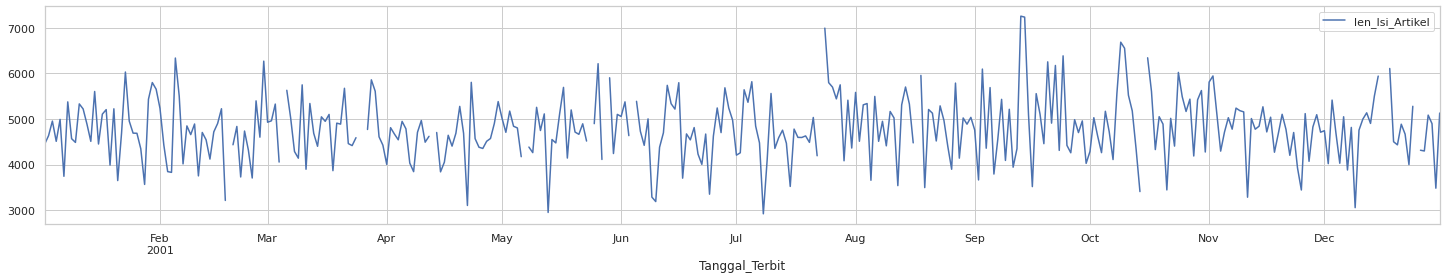

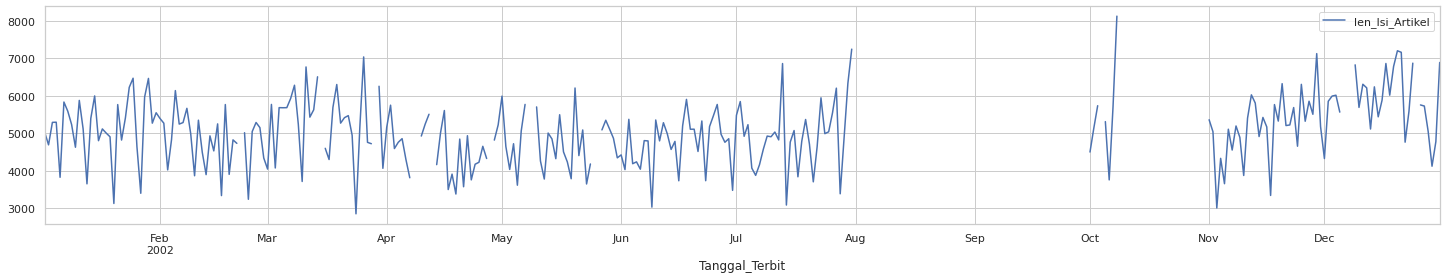

In [ ]:
trend=lenartikel_day2001_mean.plot(figsize=(25, 4))
trend=lenartikel_day2002_mean.plot(figsize=(25, 4))

plt.show()

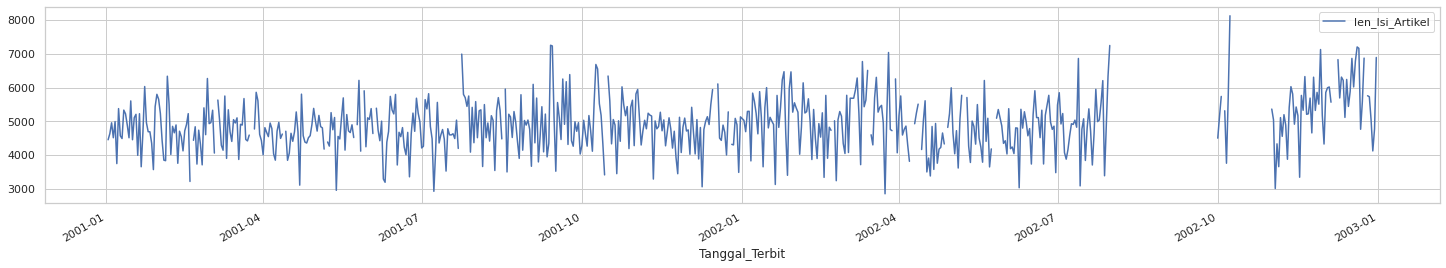

In [ ]:
lenartikel_daycombine_mean=lenartikel_day2001_mean.append(lenartikel_day2002_mean)
trend=lenartikel_daycombine_mean.plot(figsize=(25, 4))

Meski pola terkait panjang artikel tidak dapat diamati untuk frekuensi waktu harian, hal lain yang dapat dilihat antara lain terdapat beberapa bagian yang terputus, mengindikasikan bahwa ada beberapa hari (terutama pada tahun 2002) yang tidak terisi.<br><br>

---
_The pattern that is related to daily article-length is unable to identify. Moreover, many broken sections were indicating the absence of articles (especially in 2002)._

### Impute data

_credit :https://medium.com/@drnesr/filling-gaps-of-a-time-series-using-python-d4bfddd8c460_<br><br>

Untuk menyelesaikan masalah _Null Value_ pada data timeseries diatas, dapat dilakukan proses _impute_ data sebagai pengisi nilai data yang kosong.<br>
Untuk pembuatan model prediksi, saya akan melakukan _impute_ dengan metode _InterpolateTime_:<br><br>

---

_To solve the null value problem in the time-series data above, you can impute the data to fill in the empty data values. For the prediction model, I will impute it with the InterpolateTime method:_

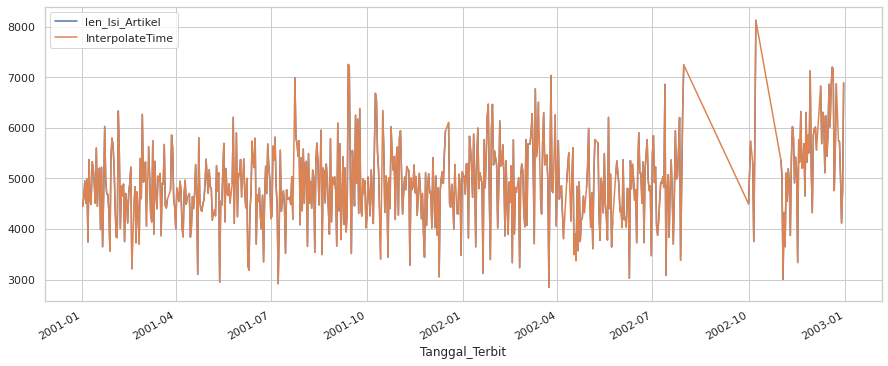

In [ ]:
impute_df=pd.DataFrame()
impute_df = lenartikel_daycombine_mean.assign(InterpolateTime=lenartikel_daycombine_mean.len_Isi_Artikel.interpolate(method='time'))

impute_df.head()
impute_df.plot(figsize=(15, 6))

### Data prediction base on _imputed_ data

_credit : https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b_<br><br>

Metode prediksi data timeseries yang akan saya gunakan adalah **ARIMA**. ARIMA memiliki 3 hyperparameter yaitu ARIMA(p,d,q).<br>
Untuk menemukan hyper parameter yang sesuai dengan dataset yang diujikan :<br><br>

---
_The time-series data prediction method that I will use is ARIMA. ARIMA has 3 hyperparameters, ARIMA (p, d, q). To find a hyperparameter that corresponds to the dataset:_

In [ ]:
impute_df=impute_df['InterpolateTime']

In [ ]:
#credit to :
#https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(impute_df, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:14486.817286703408
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:13795.328372362314


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:12091.03351303621
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:11549.4815938884
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:12102.715625517802


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:11810.917022380017
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:11772.650261025134


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:11548.47221856666
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:13981.067743158874


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:12921.298423971457
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:11998.52492774363


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:11466.084430137385


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:12022.07596812489


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:11688.985930870684


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:11691.214740553432


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:11463.098857040442
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:12021.766667650303
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:11828.611367410784
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:12304.176712350141


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:11665.615714249434
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:11845.338060101909


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:11828.807183522922
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:11909.555725696651


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:11667.593270257983
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:11689.633659989087


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:11500.813547967493


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:12030.783607333906


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:11346.488105005441
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:11533.221832524847


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:11499.022006033672


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:11659.593539134232


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:11344.495393204517
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:12033.585660848032
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:11841.553481335093


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:12020.558881091167


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:11446.06803985606
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:11841.350536210375


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:11676.28082720783


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:11651.600604434665


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:11447.474588524847
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:11712.93198223826


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:11524.4305725767
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:12000.398082289237


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:11351.800225251362


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:11540.857928294945
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:11524.715162163955


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:11628.546805612114


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:11351.658610763727
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:11872.430117260563
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:11676.161151391045
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:12225.855667462576


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:11524.255901209854
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:11676.33380806099


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:11678.039511594048


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:11770.974669760684


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:11516.532309836706
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:11691.129687932069


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:11502.752058553833


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:11996.295948028883


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:11345.63003835018


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:11516.897527755173


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:11501.509331018886


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:11634.770394439493


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:11344.69673928199


Dari hasil diatas, diperoleh parameter dengan nilai AIC terendah adalah :<br>
SARIMAX(1, 1, 1)x(1, 1, 1, 12)<br>
Parameter ini yang akan saya gunakan sebagai hyperparameter pada metode ARIMA<br><br>

---
_From the results above, the parameters with the lowest AIC value were:
<br>SARIMAX (1, 1, 1) x (1, 1, 1, 12).<br>
 I will use this parameter as a hyperparameter in the ARIMA method._

In [ ]:
mod = sm.tsa.statespace.SARIMAX(impute_df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0661      0.045      1.486      0.137      -0.021       0.153
ma.L1         -0.8181      0.028    -29.627      0.000      -0.872      -0.764
ar.S.L12      -0.0658      0.043     -1.524      0.128      -0.150       0.019
ma.S.L12      -1.0007      0.745     -1.342      0.179      -2.462       0.460
sigma2      5.853e+05   4.46e+05      1.311      0.190    -2.9e+05    1.46e+06


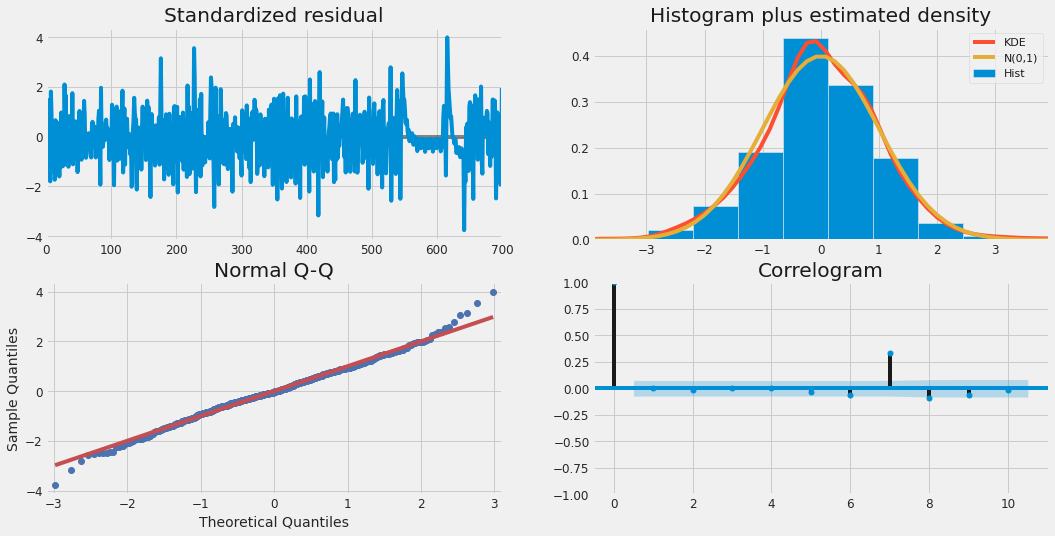

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

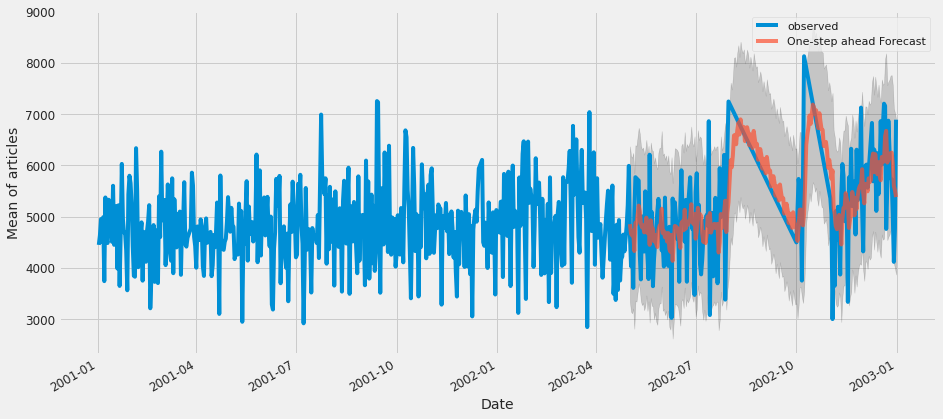

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2002-05-02'), dynamic=False)
pred_ci = pred.conf_int()
ax = impute_df['2001':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Mean of articles')
plt.legend()
plt.show()

Pada gambar grafik dapat dilihat bahwa prediksi meleset jauh dari kenyataannya, meski dari _trend_ yang dihasilkan cenderung mirip. Untuk lebih pastinya, value **RMSE** dapat dilihat seperti berikut: <br><br>

---
_The graphic image shows that the prediction is far from reality, even though the resulting trends tend to be similar. To be more precise, the RMSE value can be seen as follows:_

In [ ]:
from sklearn.metrics import mean_squared_error

y_forecasted = pred.predicted_mean
y_test = impute_df['2002-05-02':]
rmse = np.sqrt(mean_squared_error(y_test,y_forecasted))
print('RMSE dari prediksi pertama : ',rmse)

RMSE dari prediksi pertama :  768.6386881064369


### **_Bagaimana bila bulan Desember 2002 tidak disertakan dalam pembuatan model?_**
_What if December 2002 excluded from model calculation?_

In [ ]:
impute_nodes2020=impute_df[:'2002-11-30']

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(impute_nodes2020, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:13857.91742248379


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:13187.943949763034
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:11578.222241387346


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:11043.101373878915
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:11589.433692025272


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:11307.923577051395
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:11261.41146664011


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:11041.92965680912
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:13373.733495549486


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:12355.375205443826
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:11489.895486050464


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:10965.273920509459


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:11512.965756689184


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:11191.28958839403
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:11186.64274618616


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:10962.496404433845
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:11510.715291050634
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:11317.675979340172
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:11781.500992099878


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:11155.940017334437
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:11334.500524741761


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:11317.051099899512
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:11394.699080182301


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:11157.912913193066
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:11185.96662919201


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:10995.921444122569
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:11521.09937862004


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:10844.086623739204


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:11028.559300742612


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:10996.052810560805


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:11149.839953761002


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:10840.968843431574
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:11522.309969112557


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:11330.542744924995
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:11510.98064076464


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:10944.519320270814
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:11330.452288670185


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:11175.903705131026


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:11146.71392162038


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:10945.984341410414
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:11208.75203873251


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:11019.19054329196
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:11491.762252753892


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:10848.845927829683


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:11035.818941722799


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:11018.998466348581


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:11120.729429737221


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:10847.904224198865
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:11358.366138048801
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:11160.309629103474


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:11703.396761740089


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:11011.672926847308
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:11160.421123574408


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:11162.285975229799


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:11250.476139086539


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:11001.989608443264
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:11186.317763092007


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:10998.739513047265


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:11486.708519225005


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:10844.299682298686
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:11014.951299002152


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:10994.145645330977


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:11127.717957823417


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:10842.075618673884


Dari hasil diatas, diperoleh parameter dengan nilai AIC terendah adalah :<br>
SARIMAX(1, 1, 1)x(1, 1, 1, 12)<br>
Parameter ini yang akan saya gunakan sebagai hyperparameter pada metode ARIMA.<br><br>

---
_From the results above, the parameters with the lowest AIC value were:
<br>SARIMAX (1, 1, 1) x (1, 1, 1, 12).<br>
 I will use this parameter as a hyperparameter in the ARIMA method._

In [ ]:
mod = sm.tsa.statespace.SARIMAX(impute_nodes2020,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0475      0.045      1.051      0.293      -0.041       0.136
ma.L1         -0.8093      0.029    -27.974      0.000      -0.866      -0.753
ar.S.L12      -0.0802      0.043     -1.886      0.059      -0.164       0.003
ma.S.L12      -1.0005      0.047    -21.475      0.000      -1.092      -0.909
sigma2      5.832e+05   7.87e-08   7.41e+12      0.000    5.83e+05    5.83e+05


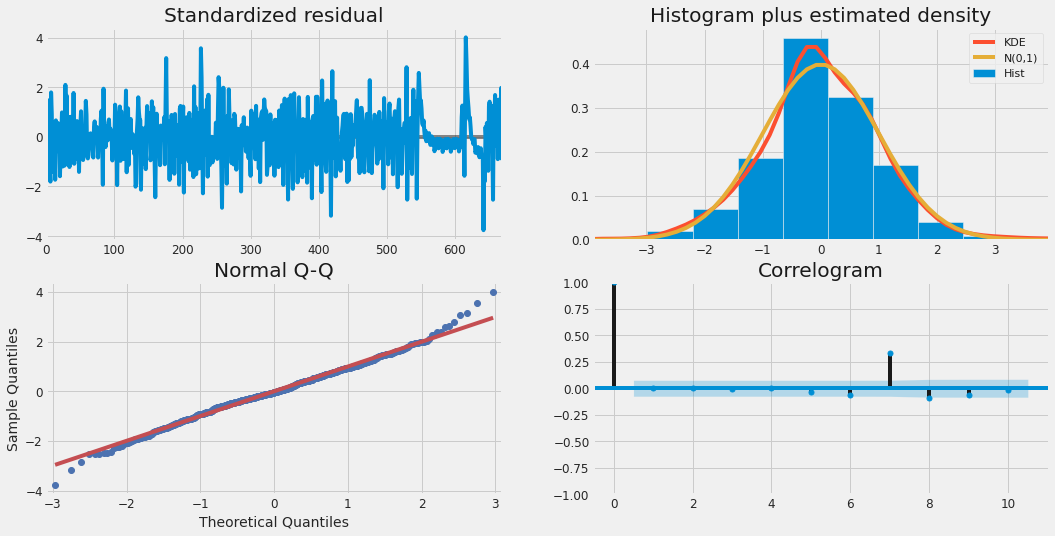

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

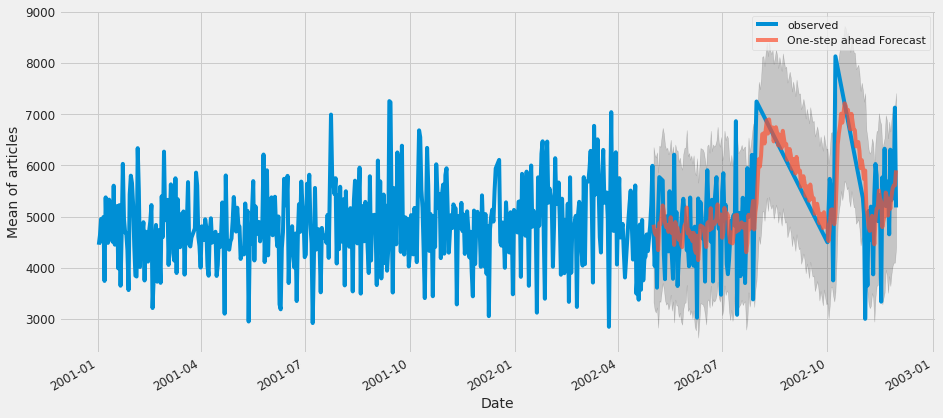

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2002-05-02'), dynamic=False)
pred_ci = pred.conf_int()
ax = impute_nodes2020['2001':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Mean of articles')
plt.legend()
plt.show()

**RMSE:**

In [ ]:
from sklearn.metrics import mean_squared_error

y_forecasted = pred.predicted_mean
y_test = impute_nodes2020['2002-05-02':]
rmse = np.sqrt(mean_squared_error(y_test,y_forecasted))
print('RMSE dari prediksi kedua : ',rmse)

RMSE dari prediksi kedua :  764.1234143623863


Tidak ada perubahan signifikan bila dilihat dari RMSE dan hasil prediksi.<br><br>

---
_It shows no significant change in RMSE and prediction results._

### **_Bila bulan Agustus dan September 2002 diasumsikan memiliki nilai yang segnifikan. Bagaimana bila perhitungan prediksi hanya dilakukan hingga bulan Juli 2002?_**
_Assumed August and September 2002 have significant value. What if the calculation only uses the data until July 2002?_ 

In [ ]:
impute_tillJul=impute_df[:'2002-7-31']

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(impute_tillJul, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:11384.646142142356


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:10794.93667715506
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:9443.524375839972


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:8898.638047089957
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:9455.787896119135


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:9174.654035305064
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:9094.643646931037


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:8900.921453766616
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:10751.921718011461


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:10141.43888768846
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:9413.492789298703


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:8883.383006982516


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:9439.823807801029


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:9123.307893975896


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:9086.586766944201


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:8884.692366484
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:9552.591547126243
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:9359.06709100744
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:9734.583131117039


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:9193.091589327561
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:9375.858536870139


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:9359.445023423788
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:9378.573335811627


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:9195.08049300867
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:9208.283285968122


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:9011.67121564651


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:9420.553100383555


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:8855.13326464143


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:9043.346516935188


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:9012.472136077798


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:9088.935626363293


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:8853.237084263106
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:9564.851740304148
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:9372.444083621325
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:9435.495728453574


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:8896.438154719726
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:9372.321484990618


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:9202.015476065197


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:9071.379247964138


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:8898.431661707526


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:9232.349416250847
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:9045.059720722129
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:9390.936787137396


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:8867.179442405184


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:9060.97844754747


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:9047.039117654273


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:9082.371655824976


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:8866.199536161414
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:9423.28912713944
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:9225.360072403706
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:9667.816824985184


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:9070.500649991802
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:9225.278237749686


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:9227.272923356257


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:9254.064629894805


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:9060.443979841184
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:9207.465792291287


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:9020.37342710755


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:9411.962341900467


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:8854.648286989826


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:9027.030314313753


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:9022.13835768704


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:9133.683292711914


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:8853.742728450448


Dari hasil diatas, diperoleh parameter dengan nilai AIC terendah adalah :<br>
SARIMAX(1, 1, 1)x(1, 1, 1, 12)<br>
Parameter ini yang akan saya gunakan sebagai hyperparameter pada metode ARIMA.<br><br>

---
_From the results above, the parameters with the lowest AIC value were:
<br>SARIMAX (1, 1, 1) x (1, 1, 1, 12).<br>
 I will use this parameter as a hyperparameter in the ARIMA method._

In [ ]:
mod = sm.tsa.statespace.SARIMAX(impute_tillJul,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0562      0.042      1.351      0.177      -0.025       0.138
ma.L1         -1.0201      0.012    -84.601      0.000      -1.044      -0.996
ar.S.L12      -0.0720      0.046     -1.565      0.117      -0.162       0.018
ma.S.L12      -1.0009      0.060    -16.626      0.000      -1.119      -0.883
sigma2       5.37e+05    1.1e-07   4.87e+12      0.000    5.37e+05    5.37e+05


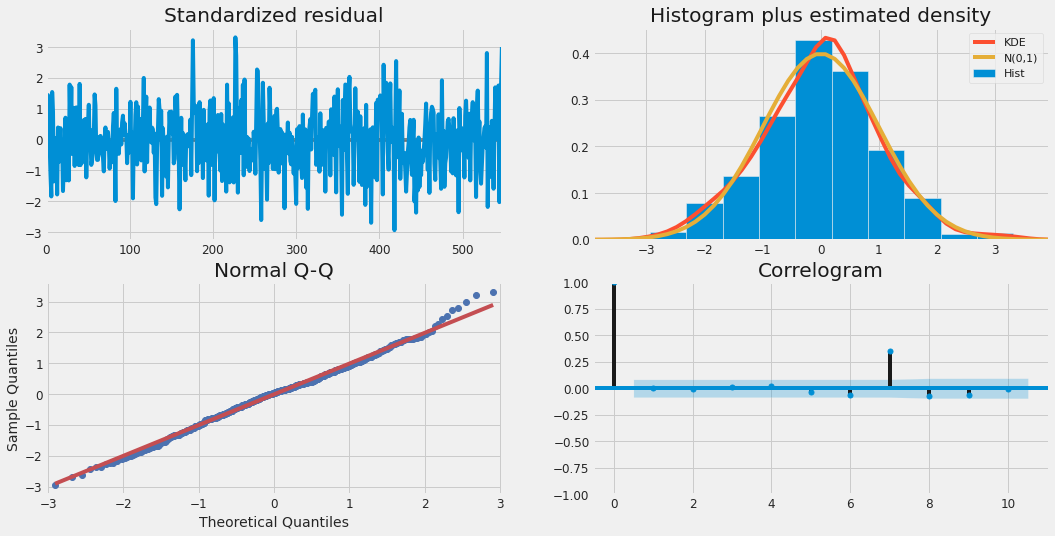

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

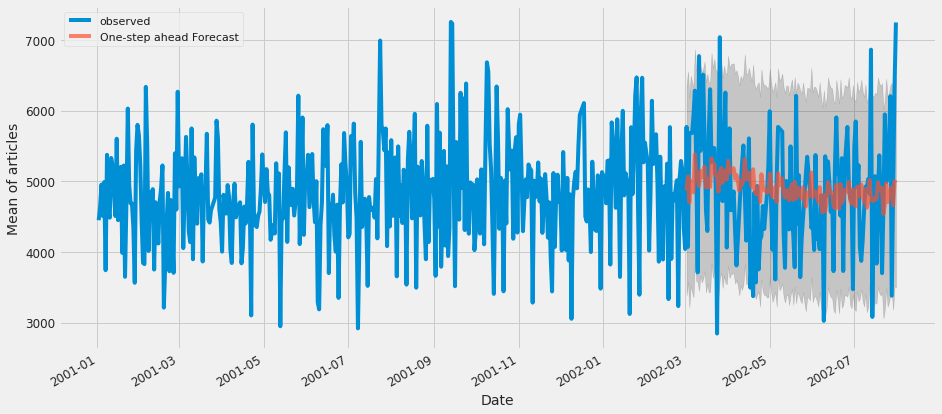

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2002-03-02'), dynamic=False)
pred_ci = pred.conf_int()
ax = impute_tillJul['2001':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Mean of articles')
plt.legend()
plt.show()

**RMSE:**

In [ ]:
from sklearn.metrics import mean_squared_error

y_forecasted = pred.predicted_mean
y_test = impute_tillJul['2002-03-02':]
rmse = np.sqrt(mean_squared_error(y_test,y_forecasted))
print('RMSE dari prediksi ketiga : ',rmse)

RMSE dari prediksi ketiga :  817.253491458696


##**(Kesimpulan dari jawaban ke-3 berdasarkan hasil prediksi)**
_**The conclusion of the third answer refers to all prediction results.**_<br><br>

Prediksi timeseries menggunakan metode ARIMA dengan 3 alternatif memberikan gambaran sebagai berikut:

1. Keseluruhan dataframe hasil impute (RMSE = 768.6387210471589)
2. Dataframe tanpa bulan Desember 2002 (RMSE = 764.123415752567)
3. Dataframe dari Januari 2001 hingga Juli 2002 (RMSE = 817.2520396309494)<br>

Dari hasil RMSE diatas, kita dapat mengetahui bahwa penghapusan data rata-rata panjang artikel bulan Desember 2002 tidak membawa pengaruh yang cukup segnifikan terhadap model yang dibuat (meskipun RMSE turun sedikit).<br>
Sebaliknya, dengan membuat model dengan dataframe hingga Juli 2002 (dengan harapan hasil impute masih dapat merepresentasikan kondisi sesungguhnya) justu membuat nilai RMSE melonjak.<br>

Berdasarkan dari dataset yang ada, meskipun rata panjang artikel memiliki korelasi antara tahun 2001 dan 2002, **tidak ditemukan** adanya menemukan pola yang segnifikan bila diamati rata-rata perharinya. Hal tersebut yang menyebabkan hasil prediksi memiliki nilai error yang cukup tinggi terlepas dengan variasi pemotongan dataframe yang dilakukan.<br><br>

---

_Timeseries prediction using the ARIMA method with 3 alternatives provides the following description:_

1. _Imputed dataframe results (RMSE = 768.6387210471589)_ 
2. _Dataframe without December 2002 (RMSE = 764.123415752567)_ 
3. _Dataframe from January 2001 to July 2002 (RMSE = 817.2520396309494)_ 

_The RMSE results between imputed dataframe and dataframe excluding December indicate that the average value for the length of articles in December 2002 has an insignificant effect. On the other hand, using a dataframe from January 2001 until July 2002 (with result expectation, minor imputed data volume doesn't increase bias between result and real condition) produces a significantly higher RMSE value._


_Although the average of the article's length in 2001 and 2002 correlate with one another, there is no significant pattern in the daily average value. Consequently, the prediction results have a fairly high error value regardless of the dataset's segmentation variant._


#Untuk pengembangan lebih lanjut
**_For further future exploration_**<br><br>

Tujuan utama dari analisa ini adalah untuk menemukan pola-pola khusus yang dinilai dapat membantu publisher baru dalam menentukan artikel berita yang harus mereka terbitkan, baik dari sisi panjang artikel maupun frekuensi keluarnya artikel dengan tema yang sama dalam satu hari seperti yang banyak ditemui di media besar.<br><br>
Masih banyak hal yang dapat dieksplorasi terkait dengan data artikel media masa online bila beberapa atribut lain dapat diketahui seperti :

1. Kernel jenis berita
2. Editor
3. Reporter
4. Jam publish
5. Jumlah Pembaca
6. Komentar<br>

Selain dari keterbatasannya data yang tersedia, juga masih banyak ditemui nilai _Null_ yang bisa jadi membawa arah analisa ke pola tertentu yang bisa ditemukan dan membantu dalam proses pembuatan model timeseries analisis. Diharapkan untuk projek analisis selanjutnya terkait artikel berita ada baiknya untuk melengkapi dataset dengan kriteria-kriteria yang disebutkan diatas<br><br>

---

_The main purpose of this analysis is to find specific patterns to help the new publishers to determine the articles to publish, based on the length of articles and appearance frequency, regarding mainstream media._

_For further exploration related to the news articles were able to do by adding more data attributes, such as:_


1. _News type kernel_
2. _Editor_
3. _Reporter_
4. _Detailed published timestamp_
5. _Readership_
6. _Comment_

_Limited data and many Null values significantly affected the process to found a pattern in the data and making the best model out of it. For a better analysis project related to news articles, we need further consideration to complete the dataset using the criteria mentioned._